# Load Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymysql     
import statsmodels.api as sm

In [375]:
# Transform

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# Models

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_squared_error

In [2]:
pd.reset_option('display.max_rows')

# 1. Load Data

I found a number of datasets in regards to Deutsche Bahn. They are as follows:

1. Train schedule arrival data for the period of May - August 2022 including delays (arrivals.csv)
2. Train schedule departure data for the period of May - August 2022 including delays (departures.csv)
3. Train Station Data for Germany including Geo-coordinates (stops.txt)
4. Stop Data (including route and stop ID) (stop_times.txt)
5. Route information (incuding type of service, such as regional, overnight etc) (routes.txt)
6. Trip information (information on scheduled trips on the network) (trips.txt)

I will perform an initial analyisis of all the datasets to better understand the content before cleaning/removing data and any unecessary information, but also understand if all the information I have is there to do the project. Unfortunately where I downloaded the dataset (https://gtfs.de/en/feeds/) didn't provide any clarification or description for the labels. Some are clear, some are not so clear.

In [3]:
arrive = pd.read_csv('arrivals.csv')
depart = pd.read_csv('departures.csv')
stops = pd.read_csv('stops.txt')
stop_times = pd.read_csv('stop_times.txt')
routes = pd.read_csv('routes.txt')
trips = pd.read_csv('trips.txt')
calendar = pd.read_csv('calendar_dates.txt')

In [4]:
display(calendar.head(50))

,service_id,exception_type,date
0,1,1,20231226
1,10,1,20240101
2,100,1,20231231
3,100,1,20240101
4,102,1,20231226
5,104,1,20231225
6,105,2,20231224
7,106,1,20231226
8,106,2,20231218
9,108,1,20231223


# 2. Review Data

### Reviewing Arrival Data

In [5]:
display(arrive.shape)
display(arrive.head(10))

(428595, 5)

,Ankunft,Zugnr.,von (Abfahrt),Ankunftsbhf.,date
0,00:25,ICE 500,München Hbf (ab 18:56),Berlin Gesundbrunnen,2022-05-01
1,01:10,ICE 1100,München Hbf (ab 19:56),Berlin Gesundbrunnen,2022-05-01
2,06:42,IC 94,Wien Hbf (ab 19:15),Berlin Gesundbrunnen,2022-05-01
3,08:13,ICE 698,München Hbf (ab 21:51),Berlin Gesundbrunnen,2022-05-01
4,08:17 (+2),IC 2173,Rostock Hbf (ab 06:21),Berlin Gesundbrunnen,2022-05-01
5,10:17,IC 2175,Warnemünde (ab 07:56),Berlin Gesundbrunnen,2022-05-01
6,11:16 (+2),IC 245,Münster(Westf)Hbf (ab 07:33),Berlin Gesundbrunnen,2022-05-01
7,11:39 (+3),IC 2270,Dresden Hbf (ab 09:19),Berlin Gesundbrunnen,2022-05-01
8,11:59,ICE 1042,Ostseebad Binz (ab 08:19),Berlin Gesundbrunnen,2022-05-01
9,12:17 (+1),IC 2177,Warnemünde (ab 09:56),Berlin Gesundbrunnen,2022-05-01


### Reviewing Departure Data

In [6]:
display(depart.shape)
display(depart.head(10))

(431323, 6)

,Unnamed: 0,Abfahrt,Zugnr.,nach (Ankunft),Abfahrtsbhf.,date
0,1,00:32 (+1),ICE 618,Kiel Hbf (an 11:23),Augsburg Hbf,2022-05-01
1,2,01:01 (+19),ICE 695,München Hbf (an 01:33),Augsburg Hbf,2022-05-01
2,3,03:57,ICE 616,Hamburg-Altona (an 12:29),Augsburg Hbf,2022-05-01
3,4,05:32 (+91),ICE 619,München Hbf (an 06:03),Augsburg Hbf,2022-05-01
4,5,06:05 (+1),ICE 614,Hamburg-Altona (an 14:29),Augsburg Hbf,2022-05-01
5,6,06:12,IC 2296,Heidelberg Hbf (an 08:44),Augsburg Hbf,2022-05-01
6,7,06:28,NJ 421,Innsbruck Hbf (an 09:14),Augsburg Hbf,2022-05-01
7,8,06:28,NJ 40491,Innsbruck Hbf (an 09:14),Augsburg Hbf,2022-05-01
8,9,06:59 (+6),ICE 699,München Hbf (an 07:31),Augsburg Hbf,2022-05-01
9,10,07:04,ICE 692,Berlin Gesundbrunnen (an 14:40),Augsburg Hbf,2022-05-01


In [7]:
# INTERIM COLUMN RENAMING TO ENGLISH

arrive.rename(columns={'Ankunft': 'time_arrive', 'Zugnr.': 'train', 'von (Abfahrt)': 'station_depart', 'Ankunftsbhf.': 'station_arrive'}, inplace=True)
depart.rename(columns={'Abfahrt': 'time_depart', 'Zugnr.': 'train', 'nach (Ankunft)': 'station_arrive', 'Abfahrtsbhf.': 'station_depart'}, inplace=True)

depart = depart.drop(columns=['Unnamed: 0'])

display(arrive.head(10))
display(depart.head(10))

,time_arrive,train,station_depart,station_arrive,date
0,00:25,ICE 500,München Hbf (ab 18:56),Berlin Gesundbrunnen,2022-05-01
1,01:10,ICE 1100,München Hbf (ab 19:56),Berlin Gesundbrunnen,2022-05-01
2,06:42,IC 94,Wien Hbf (ab 19:15),Berlin Gesundbrunnen,2022-05-01
3,08:13,ICE 698,München Hbf (ab 21:51),Berlin Gesundbrunnen,2022-05-01
4,08:17 (+2),IC 2173,Rostock Hbf (ab 06:21),Berlin Gesundbrunnen,2022-05-01
5,10:17,IC 2175,Warnemünde (ab 07:56),Berlin Gesundbrunnen,2022-05-01
6,11:16 (+2),IC 245,Münster(Westf)Hbf (ab 07:33),Berlin Gesundbrunnen,2022-05-01
7,11:39 (+3),IC 2270,Dresden Hbf (ab 09:19),Berlin Gesundbrunnen,2022-05-01
8,11:59,ICE 1042,Ostseebad Binz (ab 08:19),Berlin Gesundbrunnen,2022-05-01
9,12:17 (+1),IC 2177,Warnemünde (ab 09:56),Berlin Gesundbrunnen,2022-05-01


,time_depart,train,station_arrive,station_depart,date
0,00:32 (+1),ICE 618,Kiel Hbf (an 11:23),Augsburg Hbf,2022-05-01
1,01:01 (+19),ICE 695,München Hbf (an 01:33),Augsburg Hbf,2022-05-01
2,03:57,ICE 616,Hamburg-Altona (an 12:29),Augsburg Hbf,2022-05-01
3,05:32 (+91),ICE 619,München Hbf (an 06:03),Augsburg Hbf,2022-05-01
4,06:05 (+1),ICE 614,Hamburg-Altona (an 14:29),Augsburg Hbf,2022-05-01
5,06:12,IC 2296,Heidelberg Hbf (an 08:44),Augsburg Hbf,2022-05-01
6,06:28,NJ 421,Innsbruck Hbf (an 09:14),Augsburg Hbf,2022-05-01
7,06:28,NJ 40491,Innsbruck Hbf (an 09:14),Augsburg Hbf,2022-05-01
8,06:59 (+6),ICE 699,München Hbf (an 07:31),Augsburg Hbf,2022-05-01
9,07:04,ICE 692,Berlin Gesundbrunnen (an 14:40),Augsburg Hbf,2022-05-01


In [8]:
# REVIEW THE VALUE COUNTS ARRIVAL

display(arrive.station_arrive.value_counts())
display(arrive.station_depart.value_counts())
# display(arrive.train.value_counts())
# display(arrive.train.tolist())

Hannover Hbf                 27924
Hamburg Hbf                  24593
Frankfurt(Main)Hbf           23306
Düsseldorf Hbf               21746
Duisburg Hbf                 21345
Nürnberg Hbf                 20061
Mannheim Hbf                 19722
Köln Hbf                     19681
Göttingen                    16399
Essen Hbf                    16361
München Hbf                  15866
Stuttgart Hbf                15179
Fulda                        15116
Berlin Hbf (tief)            14089
Dortmund Hbf                 13895
Karlsruhe Hbf                13676
Erfurt Hbf                   13097
Würzburg Hbf                 13058
Hamburg-Altona               10451
Augsburg Hbf                 10310
Leipzig Hbf                   9905
Münster(Westf)Hbf             9218
Mainz Hbf                     9037
Bremen Hbf                    8973
Köln Messe/Deutz Gl.11-12     8741
Freiburg(Breisgau) Hbf        8130
Heidelberg Hbf                7544
Berlin Hbf                    6625
Berlin Gesundbrunnen

Zürich HB (ab 19:59)             1692
Hamburg-Altona (ab 20:35)        1644
Zürich HB (ab 10:59)             1477
Hamburg-Altona (ab 08:29)        1441
Kiel Hbf (ab 18:38)              1436
                                 ... 
Rheine (ab 14:20)                   1
Sulz(Neckar) (ab 07:00)             1
Amsterdam Centraal (ab 08:48)       1
Radolfzell (ab 06:20)               1
Heidelberg Hbf (ab 04:59)           1
Name: station_depart, Length: 3590, dtype: int64

In [9]:
# REVIEW THE VALUE COUNTS DEPARTURES

display(depart.station_arrive.value_counts())
display(depart.station_depart.value_counts())

display(depart.train.value_counts())

Zürich HB (an 09:05)                  3384
Zürich HB (an 08:05)                  1815
Hamburg-Altona (an 21:29)             1681
Hamburg-Altona (an 08:09)             1516
Hamburg-Altona (an 14:29)             1468
                                      ... 
Leipzig/Halle Flughafen (an 08:30)       1
Leipzig Hbf (an 07:02)                   1
Basel Bad Bf (an 06:58)                  1
Basel Bad Bf (an 06:11)                  1
Berlin Gesundbrunnen (an 19:17)          1
Name: station_arrive, Length: 4085, dtype: int64

Hannover Hbf                 28395
Hamburg Hbf                  24994
Frankfurt(Main)Hbf           23134
Düsseldorf Hbf               21956
Duisburg Hbf                 21495
Nürnberg Hbf                 20464
Köln Hbf                     20405
Mannheim Hbf                 20275
Göttingen                    16911
Essen Hbf                    16839
München Hbf                  15465
Fulda                        15453
Stuttgart Hbf                15266
Dortmund Hbf                 13480
Würzburg Hbf                 13471
Karlsruhe Hbf                13459
Erfurt Hbf                   13161
Berlin Hbf (tief)            12865
Augsburg Hbf                 10465
Leipzig Hbf                   9963
Hamburg-Altona                9804
Mainz Hbf                     9464
Münster(Westf)Hbf             9362
Bremen Hbf                    9177
Köln Messe/Deutz Gl.11-12     8577
Freiburg(Breisgau) Hbf        8248
Heidelberg Hbf                7668
Berlin Hbf                    6582
Berlin Gesundbrunnen

ICE 713     1502
ICE 619     1473
ICE 618     1468
ICE 614     1461
ICE 514     1459
            ... 
ic 60403       1
ec 176         1
ice 791        1
ice 871        1
ic 2064        1
Name: train, Length: 1347, dtype: int64

#### Understanding Arrival/Departure Data


Due to the smaller sample size of this data, we can can see the following information:
1. Only stations represented are the bigger stations in Germany
2. The data is split between arrival and departure information and coinciding schedules.
3. Despite being for the same period of time, the row shape is different (428595 v 431323)
4. There seems to be quite a high number of train identifiers with some anomolies (EC999999 for instance).

### Reviewing Stop (Train Station) & Schedule Data

In [10]:
# CHECK STOPS DATASET

display(stops.shape)
display(stops.head(10))

(1629, 6)

,stop_name,parent_station,stop_id,stop_lat,stop_lon,location_type
0,'s-Hertogenbosch,NaN,351617,51.690540,5.293723,1.0
1,'s-Hertogenbosch,351617.0,545208,51.690540,5.293723,NaN
2,Aachen Hbf,168299.0,270809,50.767940,6.090865,NaN
3,Aachen Süd(Gr),NaN,412112,50.731915,6.045410,1.0
4,Aachen Süd(Gr),412112.0,666257,50.731915,6.045410,NaN
5,"Aachen, Hbf,Aachen",NaN,168299,50.767723,6.092051,1.0
6,Aalen Hauptbahnhof,NaN,473812,48.841602,10.096031,1.0
7,Aalen Hbf,473812.0,118809,48.841015,10.096271,NaN
8,Aalen Hbf,473812.0,459324,48.841680,10.096130,NaN
9,Aarhus,NaN,484274,56.150074,10.204997,1.0


In [11]:
display(stops.stop_name.value_counts())
display(stops.parent_station.value_counts())

München Hbf            26
Frankfurt(Main)Hbf     18
Karlsruhe Hbf          12
Hamburg Hbf            12
Düsseldorf Hbf         11
                       ..
Ergenzingen             1
Rheine, Bahnhof         1
Ergenzingen Bahnhof     1
Hausach                 1
Essen Hauptbahnhof      1
Name: stop_name, Length: 800, dtype: int64

210727.0    27
627253.0    19
646407.0    12
247157.0    12
414320.0    12
            ..
181453.0     1
245337.0     1
164493.0     1
448705.0     1
595415.0     1
Name: parent_station, Length: 591, dtype: int64

In [12]:
display(stops[(stops['stop_name'] == 'München Hbf')])
display(stops[(stops['location_type'] == 1.0 )])

,stop_name,parent_station,stop_id,stop_lat,stop_lon,location_type
988,München Hbf,NaN,210727,48.140290,11.559602,1.0
989,München Hbf,210727.0,145395,48.139940,11.557491,NaN
990,München Hbf,210727.0,153864,48.140970,11.557671,NaN
991,München Hbf,210727.0,206003,48.140553,11.557608,NaN
992,München Hbf,210727.0,247210,48.140385,11.557572,NaN
993,München Hbf,210727.0,251708,48.139828,11.553727,NaN
994,München Hbf,210727.0,25402,48.140160,11.553898,NaN
995,München Hbf,210727.0,263183,48.139900,11.553772,NaN
996,München Hbf,210727.0,2852,48.140236,11.557545,NaN
997,München Hbf,210727.0,299478,48.140500,11.557590,NaN


,stop_name,parent_station,stop_id,stop_lat,stop_lon,location_type
0,'s-Hertogenbosch,NaN,351617,51.690540,5.293723,1.0
3,Aachen Süd(Gr),NaN,412112,50.731915,6.045410,1.0
5,"Aachen, Hbf,Aachen",NaN,168299,50.767723,6.092051,1.0
6,Aalen Hauptbahnhof,NaN,473812,48.841602,10.096031,1.0
9,Aarhus,NaN,484274,56.150074,10.204997,1.0
...,...,...,...,...,...,...
1617,Zürich Flughafen,NaN,52098,47.450386,8.562402,1.0
1619,Zürich HB,NaN,104196,47.378178,8.540212,1.0
1621,Züssow,NaN,620099,53.975050,13.547026,1.0
1625,Ötztal,NaN,237368,47.238483,10.859114,1.0


In [13]:
# CHECK STOP_TIMES (SCHEDULE) DATASET

display(stop_times.shape)
display(stop_times.head(10))

(63956, 7)

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type
0,1257450,16:59:00,16:59:00,45163,0,NaN,NaN
1,1257450,17:40:00,17:42:00,385943,1,NaN,NaN
2,1257450,18:20:00,18:23:00,118645,2,NaN,NaN
3,1257450,19:02:00,19:07:00,162176,3,NaN,NaN
4,1257450,19:36:00,19:36:00,6303,4,NaN,NaN
5,1308687,12:59:00,12:59:00,45163,0,NaN,NaN
6,1308687,13:40:00,13:42:00,385943,1,NaN,NaN
7,1308687,14:20:00,14:23:00,118645,2,NaN,NaN
8,1308687,15:02:00,15:07:00,162176,3,NaN,NaN
9,1308687,15:36:00,15:36:00,6303,4,NaN,NaN


In [14]:
display(stop_times.stop_id.value_counts())
display(stop_times.pickup_type.value_counts())
display(stop_times[(stop_times['stop_id'] == 2852)])

159474    1325
155438    1259
615228    1076
91205     1024
192425     886
          ... 
265019       1
65780        1
246702       1
222358       1
249679       1
Name: stop_id, Length: 1038, dtype: int64

1.0    3435
Name: pickup_type, dtype: int64

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type
61066,1061787,18:49:00,18:49:00,2852,6,NaN,NaN
61678,423095,13:03:00,13:03:00,2852,0,NaN,NaN
61922,986611,13:03:00,13:03:00,2852,0,NaN,NaN


In [15]:
# CHECK THE VALUE COUNTS OF STOP SEQUENCE, PICKUP & DROPOFF

display(stop_times.pickup_type.value_counts())
display(stop_times.drop_off_type.value_counts())
display(stop_times.stop_sequence.value_counts())

1.0    3435
Name: pickup_type, dtype: int64

1.0    3307
Name: drop_off_type, dtype: int64

0     5617
1     5617
2     5393
3     5191
4     4957
5     4703
6     4368
7     4018
8     3612
9     3217
10    2875
11    2614
12    2247
13    1851
14    1547
15    1243
16    1004
17     817
18     681
19     549
20     404
21     353
22     266
23     229
24     191
25     152
26      94
27      59
28      34
29      17
30      14
31      12
32       8
33       1
34       1
Name: stop_sequence, dtype: int64

#### Understanding Stop & Schedule Data

What I understood from the dataset:

1. Initially I see 1600+ stops, but there are multiple counts when I see check the 'stop_name' column.
2. Bigger hubs, like München Hbf, have multiple stop IDs under a parent station I assume this correlates to the  track platforms. 
3. Longitude and Latitude data is also provided for parent and sub-sequent stop IDs.
4. Initially I see 1600+ stops, but there see
5. Location type values are 1.0 or NaN. Based on above, 1.0 would indicate parent station.
6. Cross checked the value counts for Parent Station and where Location Type is 1.0 and it matches the value 591. 
7. We can confirm there are 591 train station/hubs in Germany.
8. In the Stop Times (Schedule) dataset, it is unclear what pickup/dropoff types mean with binary 1.0.

### Review Routes & Trips Data

In [16]:
# CHECK ROUTES

display(routes.shape)
display(routes.head(10))

(129, 5)

,route_long_name,route_short_name,agency_id,route_type,route_id
0,EC,EC,10,2,35
1,EC,EC,13,2,96
2,EC,EC,2,2,1
3,EC,EC,5,2,83
4,EC,EC,7,2,120
5,EC,EC,9,2,29
6,EN,EN,1,2,108
7,EN,EN,10,2,8
8,EN,EN,13,2,33
9,EN,EN,14,2,76


In [17]:
display(routes.route_long_name.value_counts())
display(routes.route_short_name.value_counts())
display(routes.agency_id.value_counts())
display(routes.route_type.value_counts())
display(routes.route_id.value_counts())

Intercity-Express    50
Intercity            28
EuroCity             18
IC                    7
EC                    6
EN                    6
EuroNight             6
EuroCity-Express      3
ICE                   3
RJ                    2
Name: route_long_name, dtype: int64

IC        7
EC        6
EN        6
ICE       3
EN 62     3
         ..
IC 75     1
IC 62     1
IC 61     1
IC 60     1
ICE 10    1
Name: route_short_name, Length: 93, dtype: int64

6     80
5     14
9      6
12     5
1      4
13     3
7      3
10     2
2      2
14     2
8      2
11     2
3      2
4      2
Name: agency_id, dtype: int64

2    129
Name: route_type, dtype: int64

35     1
16     1
107    1
125    1
4      1
      ..
122    1
37     1
23     1
9      1
32     1
Name: route_id, Length: 129, dtype: int64

In [18]:
display(routes[(routes['route_long_name'] == 'Intercity')])
display(routes[(routes['route_short_name'] == 'IC')])
display(routes[(routes['route_id'] == 108)])

,route_long_name,route_short_name,agency_id,route_type,route_id
49,Intercity,IC 1,11,2,72
50,Intercity,IC 12,12,2,127
51,Intercity,IC 17,6,2,118
52,Intercity,IC 20,12,2,79
53,Intercity,IC 24,6,2,50
54,Intercity,IC 26,6,2,110
55,Intercity,IC 27,12,2,42
56,Intercity,IC 27,6,2,105
57,Intercity,IC 29,6,2,98
58,Intercity,IC 30,6,2,123


,route_long_name,route_short_name,agency_id,route_type,route_id
39,IC,IC,1,2,104
40,IC,IC,11,2,56
41,IC,IC,12,2,46
42,IC,IC,2,2,40
43,IC,IC,3,2,84
44,IC,IC,5,2,78
45,IC,IC,9,2,41


,route_long_name,route_short_name,agency_id,route_type,route_id
6,EN,EN,1,2,108


In [19]:
# CHECK TRIPS

display(trips.shape)
display(trips.head(10))

(5617, 3)

,route_id,service_id,trip_id
0,1,107,292268
1,1,155,1587233
2,1,192,342651
3,1,258,1430454
4,1,288,1618996
5,1,30,1257450
6,1,30,1308687
7,1,30,184904
8,1,327,610896
9,1,426,1800672


In [20]:
display(trips.route_id.value_counts())
display(trips.service_id.value_counts())
display(trips.trip_id.value_counts())

11     231
12     218
20     209
125    194
69     187
      ... 
114      1
108      1
37       1
76       1
123      1
Name: route_id, Length: 129, dtype: int64

579    430
464    383
53     302
387    278
319    207
      ... 
205      1
43       1
83       1
533      1
420      1
Name: service_id, Length: 611, dtype: int64

292268     1
966496     1
1698121    1
1673878    1
162829     1
          ..
117935     1
1019340    1
535123     1
1083254    1
665356     1
Name: trip_id, Length: 5617, dtype: int64

In [21]:
# CHECK TO SEE IF THE MOST COUNTS OF TRAIN FROM THE ARRIVE/DEPART DATASET IS VISIBLE
# IC 619 or EC 6 TRAIN AND SOME VARIATIONS

display(routes[(routes['route_short_name'] == 'IC 619')])
display(routes[(routes['route_id'] == 619)])
display(trips[(trips['service_id'] == 619)])
display(trips[(trips['route_id'] == 619)])

display(routes[(routes['route_short_name'] == 'EC 6')])
display(routes[(routes['route_id'] == 6)])
display(trips[(trips['service_id'] == 6)])
display(trips[(trips['route_id'] == 6)])

,route_long_name,route_short_name,agency_id,route_type,route_id


,route_long_name,route_short_name,agency_id,route_type,route_id


,route_id,service_id,trip_id


,route_id,service_id,trip_id


,route_long_name,route_short_name,agency_id,route_type,route_id


,route_long_name,route_short_name,agency_id,route_type,route_id
117,Intercity-Express,ICE 79,6,2,6


,route_id,service_id,trip_id
3850,59,6,1626247


,route_id,service_id,trip_id
3856,6,122,750469
3857,6,125,314235
3858,6,16,142794
3859,6,16,17889
3860,6,16,791795
...,...,...,...
3957,6,85,842101
3958,6,93,1660680
3959,6,93,1823999
3960,6,93,339790


#### Understanding Routes & Trip Data

After analysing some of the data above when it comes to trips:
1. The routes dataset requires some cleaning as there seems to be some double names (eg. ICE and InterCity-Express refer to the same train type).
2. Checked for existing trains from the Arrive/Depart dataset to see if this correlates to the Routes/Trips and it seems the numbers do not match. There could be missing data.
3. Tested some variations of the values, to understand if there are any patterns between route, service and the train numbers from the first set and it seems they are quite disconnected.
4. Assumption could be that this dataset is not complete as have searched for train numbers from the Arrive/Depart set in Google, and they are still valid trains, which do not appear in this set.

## Overall Conclusions

After my initial data exploration, it seems the information I have in regards to the route/trip IDs feels either incomplete or doesn't have the right information and context to align back to the Arrive/Depart dataset. From my perspective, it doesn't make sense to utilise data that is I cannot wrangle back to the original brief. Instead I will focus on add more context to the Arrive/Data set to understand train punctuality on the existing operating services and develop a model from this. 

# 3. Clean Data

In [22]:
# Check the data again

display(depart.head(20))
display(arrive.head(20))
display(depart.dtypes)
display(arrive.dtypes)

,time_depart,train,station_arrive,station_depart,date
0,00:32 (+1),ICE 618,Kiel Hbf (an 11:23),Augsburg Hbf,2022-05-01
1,01:01 (+19),ICE 695,München Hbf (an 01:33),Augsburg Hbf,2022-05-01
2,03:57,ICE 616,Hamburg-Altona (an 12:29),Augsburg Hbf,2022-05-01
3,05:32 (+91),ICE 619,München Hbf (an 06:03),Augsburg Hbf,2022-05-01
4,06:05 (+1),ICE 614,Hamburg-Altona (an 14:29),Augsburg Hbf,2022-05-01
5,06:12,IC 2296,Heidelberg Hbf (an 08:44),Augsburg Hbf,2022-05-01
6,06:28,NJ 421,Innsbruck Hbf (an 09:14),Augsburg Hbf,2022-05-01
7,06:28,NJ 40491,Innsbruck Hbf (an 09:14),Augsburg Hbf,2022-05-01
8,06:59 (+6),ICE 699,München Hbf (an 07:31),Augsburg Hbf,2022-05-01
9,07:04,ICE 692,Berlin Gesundbrunnen (an 14:40),Augsburg Hbf,2022-05-01


,time_arrive,train,station_depart,station_arrive,date
0,00:25,ICE 500,München Hbf (ab 18:56),Berlin Gesundbrunnen,2022-05-01
1,01:10,ICE 1100,München Hbf (ab 19:56),Berlin Gesundbrunnen,2022-05-01
2,06:42,IC 94,Wien Hbf (ab 19:15),Berlin Gesundbrunnen,2022-05-01
3,08:13,ICE 698,München Hbf (ab 21:51),Berlin Gesundbrunnen,2022-05-01
4,08:17 (+2),IC 2173,Rostock Hbf (ab 06:21),Berlin Gesundbrunnen,2022-05-01
5,10:17,IC 2175,Warnemünde (ab 07:56),Berlin Gesundbrunnen,2022-05-01
6,11:16 (+2),IC 245,Münster(Westf)Hbf (ab 07:33),Berlin Gesundbrunnen,2022-05-01
7,11:39 (+3),IC 2270,Dresden Hbf (ab 09:19),Berlin Gesundbrunnen,2022-05-01
8,11:59,ICE 1042,Ostseebad Binz (ab 08:19),Berlin Gesundbrunnen,2022-05-01
9,12:17 (+1),IC 2177,Warnemünde (ab 09:56),Berlin Gesundbrunnen,2022-05-01


time_depart       object
train             object
station_arrive    object
station_depart    object
date              object
dtype: object

time_arrive       object
train             object
station_depart    object
station_arrive    object
date              object
dtype: object

In [23]:
# Check NaN values

print(depart.duplicated())
print(arrive.duplicated())
print(f'NaN values:',depart.isna().sum().sum())
print(f'NaN values:',arrive.isna().sum().sum())

0         False
1         False
2         False
3         False
4         False
          ...  
431318    False
431319    False
431320    False
431321    False
431322    False
Length: 431323, dtype: bool
0         False
1         False
2         False
3         False
4         False
          ...  
428590    False
428591    False
428592    False
428593    False
428594    False
Length: 428595, dtype: bool
NaN values: 0
NaN values: 0


In [24]:
depart[(depart['train'] == 'ICE 595')]

,time_depart,train,station_arrive,station_depart,date
48,14:55,ICE 595,München Hbf (an 15:28),Augsburg Hbf,2022-05-01
91,07:19,ICE 595,München Hbf (an 15:28),Berlin Gesundbrunnen,2022-05-01
141,07:28 (+1),ICE 595,München Hbf (an 15:28),Berlin Hbf (tief),2022-05-01
861,09:30,ICE 595,München Hbf (an 15:28),Erfurt Hbf,2022-05-01
1172,11:50,ICE 595,München Hbf (an 15:28),Frankfurt(Main)Hbf,2022-05-01
...,...,...,...,...,...
428995,11:50 (+70),ICE 595,München Hbf (an 15:28),Frankfurt(Main)Hbf,2022-08-31
429213,10:50 (+1),ICE 595,München Hbf (an 15:28),Fulda,2022-08-31
430348,08:48,ICE 595,München Hbf (an 15:28),Leipzig Hbf,2022-08-31
430556,12:30 (+98),ICE 595,München Hbf (an 15:28),Mannheim Hbf,2022-08-31


In [25]:
arrive[(arrive['train'] == 'ICE 595')]

,time_arrive,train,station_depart,station_arrive,date
41001,11:44,ICE 595,Berlin Gesundbrunnen (ab 07:19),Frankfurt(Main)Hbf,2022-05-01
41213,11:44 (+2),ICE 595,Berlin Gesundbrunnen (ab 07:19),Frankfurt(Main)Hbf,2022-05-02
41420,11:44 (+4),ICE 595,Berlin Gesundbrunnen (ab 07:19),Frankfurt(Main)Hbf,2022-05-03
41622,11:44 (+1),ICE 595,Berlin Gesundbrunnen (ab 07:19),Frankfurt(Main)Hbf,2022-05-04
41821,11:44,ICE 595,Berlin Gesundbrunnen (ab 07:19),Frankfurt(Main)Hbf,2022-05-05
...,...,...,...,...,...
417696,14:53 (+66),ICE 595,Berlin Gesundbrunnen (ab 07:19),Augsburg Hbf,2022-08-27
417761,14:53 (+2),ICE 595,Leipzig Hbf (ab 08:48),Augsburg Hbf,2022-08-28
417845,14:53 (+3),ICE 595,Berlin Gesundbrunnen (ab 07:19),Augsburg Hbf,2022-08-29
417942,14:53 (+42),ICE 595,Berlin Gesundbrunnen (ab 07:19),Augsburg Hbf,2022-08-30


In [26]:
arrive[(arrive['train'] == 'IC 94') & (arrive['date'] == '2022-05-05')]

,time_arrive,train,station_depart,station_arrive,date
159,06:42,IC 94,Wien Hbf (ab 19:15),Berlin Gesundbrunnen,2022-05-05
3311,06:31,IC 94,Wien Hbf (ab 19:15),Berlin Hbf (tief),2022-05-05
104526,04:50,IC 94,Wien Hbf (ab 19:15),Leipzig Hbf,2022-05-05
119444,00:00 (+7),IC 94,Wien Hbf (ab 19:15),Nürnberg Hbf,2022-05-05


### Clean Arrival Data

This process involves:
1. Cleaning up the names of the stations, to simplify them.
2. Creating a new column for 'delay' by extracting the delay time from the 'time_arrive' column.
3. Separating the train types and numbers to help create clusters on seeing what types of services are delayed.
4. Removing 

In [27]:
arrive['time_arrive'] = arrive['time_arrive'].astype(str)

In [28]:
# Extract 'late' time values into a new column
# Fill NaN values in 'delay' column with 0

arrive['delay'] = arrive['time_arrive'].str.extract(r'\(\+(\d+)\)', expand=False).astype(float)
arrive['delay'] = arrive['delay'].fillna(0)

display(arrive.head(20))

,time_arrive,train,station_depart,station_arrive,date,delay
0,00:25,ICE 500,München Hbf (ab 18:56),Berlin Gesundbrunnen,2022-05-01,0.0
1,01:10,ICE 1100,München Hbf (ab 19:56),Berlin Gesundbrunnen,2022-05-01,0.0
2,06:42,IC 94,Wien Hbf (ab 19:15),Berlin Gesundbrunnen,2022-05-01,0.0
3,08:13,ICE 698,München Hbf (ab 21:51),Berlin Gesundbrunnen,2022-05-01,0.0
4,08:17 (+2),IC 2173,Rostock Hbf (ab 06:21),Berlin Gesundbrunnen,2022-05-01,2.0
5,10:17,IC 2175,Warnemünde (ab 07:56),Berlin Gesundbrunnen,2022-05-01,0.0
6,11:16 (+2),IC 245,Münster(Westf)Hbf (ab 07:33),Berlin Gesundbrunnen,2022-05-01,2.0
7,11:39 (+3),IC 2270,Dresden Hbf (ab 09:19),Berlin Gesundbrunnen,2022-05-01,3.0
8,11:59,ICE 1042,Ostseebad Binz (ab 08:19),Berlin Gesundbrunnen,2022-05-01,0.0
9,12:17 (+1),IC 2177,Warnemünde (ab 09:56),Berlin Gesundbrunnen,2022-05-01,1.0


In [29]:
# Clean Up Station Names

In [30]:
arrive['time_arrive'] = arrive['time_arrive'].str.replace(r'\(\+\d+\)', '').str.strip()

/var/folders/yq/dfhgy0yx0t3dm3n1xyhjfyjw0000gn/T/ipykernel_17702/559679252.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  arrive['time_arrive'] = arrive['time_arrive'].str.replace(r'\(\+\d+\)', '').str.strip()


In [31]:
arrive['time_depart'] = arrive['station_depart'].str.extract(r'ab (\d+:\d+)', expand=False)
arrive['station_depart'] = arrive['station_depart'].str.replace(r'\(.*\)', '').str.strip()

/var/folders/yq/dfhgy0yx0t3dm3n1xyhjfyjw0000gn/T/ipykernel_17702/3364143207.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  arrive['station_depart'] = arrive['station_depart'].str.replace(r'\(.*\)', '').str.strip()


In [32]:
# Simplify the station names by removing 'hbf' - this indicates main station. 

arrive['station_arrive'] = arrive['station_arrive'].str.replace(r'\([^)]*\)', '').str.strip()
# arrive['station_depart'].replace({'hbf': 'HBF', 'Hauptbahnhof': 'HBF', 'HB': 'HBF', 'Hbf': 'HBF'}, inplace=True)

hbf_to_replace = ['hbf', 'Hauptbahnhof', 'Hbf']

for pattern in hbf_to_replace:
    arrive['station_arrive'] = arrive['station_arrive'].str.replace(pattern, 'HBF', case=True)
    arrive['station_depart'] = arrive['station_depart'].str.replace(pattern, 'HBF', case=True)


display(arrive['station_arrive'])
display(arrive['station_depart'])

/var/folders/yq/dfhgy0yx0t3dm3n1xyhjfyjw0000gn/T/ipykernel_17702/2997163462.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  arrive['station_arrive'] = arrive['station_arrive'].str.replace(r'\([^)]*\)', '').str.strip()


0         Berlin Gesundbrunnen
1         Berlin Gesundbrunnen
2         Berlin Gesundbrunnen
3         Berlin Gesundbrunnen
4         Berlin Gesundbrunnen
                  ...         
428590            Freiburg HBF
428591            Freiburg HBF
428592            Freiburg HBF
428593            Freiburg HBF
428594            Freiburg HBF
Name: station_arrive, Length: 428595, dtype: object

0         München HBF
1         München HBF
2            Wien HBF
3         München HBF
4         Rostock HBF
             ...     
428590      Zürich HB
428591      Frankfurt
428592       Köln HBF
428593       Kiel HBF
428594     Berlin HBF
Name: station_depart, Length: 428595, dtype: object

In [33]:
display(arrive['station_arrive'].value_counts())
display(arrive['station_depart'].value_counts())

Hannover HBF                 27924
Hamburg HBF                  24593
FrankfurtHBF                 23306
Düsseldorf HBF               21746
Duisburg HBF                 21345
Berlin HBF                   20714
Nürnberg HBF                 20061
Mannheim HBF                 19722
Köln HBF                     19681
Göttingen                    16399
Essen HBF                    16361
München HBF                  15866
Stuttgart HBF                15179
Fulda                        15116
Dortmund HBF                 13895
Karlsruhe HBF                13676
Erfurt HBF                   13097
Würzburg HBF                 13058
Hamburg-Altona               10451
Augsburg HBF                 10310
Leipzig HBF                   9905
MünsterHBF                    9218
Mainz HBF                     9037
Bremen HBF                    8973
Köln Messe/Deutz Gl.11-12     8741
Freiburg HBF                  8130
Heidelberg HBF                7544
Berlin Gesundbrunnen          5315
München Ost         

München HBF          71290
Hamburg-Altona       60195
Köln HBF             25922
Frankfurt            21840
Berlin Ostbahnhof    21425
                     ...  
Böblingen                1
Mühlacker                1
Metzingen                1
Wanne-Eickel HBF         1
Ringsted St              1
Name: station_depart, Length: 316, dtype: int64

In [34]:
arrive['station_arrive'] = arrive['station_arrive'].replace('Köln Messe/Deutz Gl.11-12', 'Köln Messe')

In [35]:
# Split 'train' into two columns, one for type of service and train number.

arrive[['train_type', 'train_num']] = arrive['train'].str.extract(r'([A-Za-z]+) (\d+)', expand=True)
arrive = arrive.drop('train', axis=1)

In [36]:
# Noticed anomaly in the 'time_arrive' colum, check the instances 

non_numeric_mask = arrive['time_arrive'].str.contains(r'[^0-9:]')

rows_with_non_numeric = arrive[non_numeric_mask]
display(rows_with_non_numeric)

,time_arrive,station_depart,station_arrive,date,delay,time_depart,train_type,train_num
48,09:40 Ausfall,Dresden HBF,Berlin Gesundbrunnen,2022-05-02,0.0,07:19,IC,2912
49,10:02 Ausfall,Stralsund HBF,Berlin Gesundbrunnen,2022-05-02,0.0,07:24,ICE,1044
67,16:17 Ausfall,Warnemünde,Berlin Gesundbrunnen,2022-05-02,0.0,13:52,IC,2911
237,08:13 Ausfall,München HBF,Berlin Gesundbrunnen,2022-05-07,0.0,21:51,ICE,698
248,13:05 Ausfall,Saarbrücken HBF,Berlin Gesundbrunnen,2022-05-07,0.0,06:28,ICE,935
...,...,...,...,...,...,...,...,...
428473,05:51 Ausfall,Basel SBB,Freiburg HBF,2022-08-30,0.0,05:06,ICE,206
428487,09:55 Ausfall,Basel SBB,Freiburg HBF,2022-08-30,0.0,09:13,ICE,200
428510,16:11 Ausfall,Hamburg-Altona,Freiburg HBF,2022-08-30,0.0,09:44,ICE,75
428566,14:53 Ausfall,Basel SBB,Freiburg HBF,2022-08-31,0.0,14:13,ICE,276


In [37]:
# Ausfall indicates there has been a train failure or cancelation

# 24307 / 428595 = 0.056

# Based on the row values, it is approximately 5% of all the services
# With this ifnromation, I want to keep the values but extra and create a new column


arrive['canceled'] = np.where(arrive['time_arrive'].str.contains('Ausfall'), 1, 0)
arrive['time_arrive'] = arrive['time_arrive'].str.replace(r'Ausfall', '')

display(arrive['canceled'].value_counts())

0    404288
1     24307
Name: canceled, dtype: int64

In [38]:
# Look at the distribution of values

mean_value = arrive['station_depart'].value_counts().mean()
median_value = arrive['station_depart'].value_counts().median()
std_value = arrive['station_depart'].value_counts().std()

print(f"Mean: {mean_value}, Median: {median_value}, Standard Deviation: {std_value}")

Mean: 1356.3132911392406, Median: 36.0, Standard Deviation: 5968.445931035628


In [39]:
# There is quite a high deviation of values from the mea
# In this instance, based on the value counts, let's check the values above the mean

threshold = 1000

arrive_outliers = arrive['station_arrive'].value_counts()[arrive['station_arrive'].value_counts() > threshold]
depart_outliers = arrive['station_depart'].value_counts()[arrive['station_depart'].value_counts() > threshold]


display(arrive_outliers)
display(depart_outliers)

Hannover HBF            27924
Hamburg HBF             24593
FrankfurtHBF            23306
Düsseldorf HBF          21746
Duisburg HBF            21345
Berlin HBF              20714
Nürnberg HBF            20061
Mannheim HBF            19722
Köln HBF                19681
Göttingen               16399
Essen HBF               16361
München HBF             15866
Stuttgart HBF           15179
Fulda                   15116
Dortmund HBF            13895
Karlsruhe HBF           13676
Erfurt HBF              13097
Würzburg HBF            13058
Hamburg-Altona          10451
Augsburg HBF            10310
Leipzig HBF              9905
MünsterHBF               9218
Mainz HBF                9037
Bremen HBF               8973
Köln Messe               8741
Freiburg HBF             8130
Heidelberg HBF           7544
Berlin Gesundbrunnen     5315
München Ost              4689
Dresden HBF              4543
Name: station_arrive, dtype: int64

München HBF             71290
Hamburg-Altona          60195
Köln HBF                25922
Frankfurt               21840
Berlin Ostbahnhof       21425
Stuttgart HBF           17894
Dortmund HBF            13692
Berlin Gesundbrunnen    10405
Zürich HB               10001
Essen HBF                9691
Basel SBB                9532
Karlsruhe HBF            8555
Dresden HBF              8482
Düsseldorf HBF           7643
Wiesbaden HBF            6222
Kiel HBF                 6208
Amsterdam Centraal       6183
Wien HBF                 6152
Nürnberg HBF             5138
Leipzig HBF              4340
Münster                  4305
Ostseebad Binz           4154
Berlin HBF               3737
Interlaken Ost           3705
Paris Est                3000
Hannover HBF             2977
Hamburg HBF              2900
Westerland               2834
Bonn HBF                 2430
Norddeich Mole           2395
Innsbruck HBF            2256
Bremen HBF               2220
Berlin Südkreuz          2205
Praha hl.n

In [40]:
# Let's check percentile threshold to make sure the values
# In this case, I want to check the 90% percentile

percentile_threshold = arrive['station_depart'].value_counts().quantile(0.90)
print(f"Threshold for the 90th percentile: {percentile_threshold}")

Threshold for the 90th percentile: 2212.5


In [41]:
# Check the unique values that fits within the 90% percentile

depart_outliers = arrive['station_depart'].value_counts()[arrive['station_depart'].value_counts() > percentile_threshold]
print(depart_outliers)

München HBF             71290
Hamburg-Altona          60195
Köln HBF                25922
Frankfurt               21840
Berlin Ostbahnhof       21425
Stuttgart HBF           17894
Dortmund HBF            13692
Berlin Gesundbrunnen    10405
Zürich HB               10001
Essen HBF                9691
Basel SBB                9532
Karlsruhe HBF            8555
Dresden HBF              8482
Düsseldorf HBF           7643
Wiesbaden HBF            6222
Kiel HBF                 6208
Amsterdam Centraal       6183
Wien HBF                 6152
Nürnberg HBF             5138
Leipzig HBF              4340
Münster                  4305
Ostseebad Binz           4154
Berlin HBF               3737
Interlaken Ost           3705
Paris Est                3000
Hannover HBF             2977
Hamburg HBF              2900
Westerland               2834
Bonn HBF                 2430
Norddeich Mole           2395
Innsbruck HBF            2256
Bremen HBF               2220
Name: station_depart, dtype: int64


In [42]:
# Convert the date and find day of the week as a new column

arrive['date'] = pd.to_datetime(arrive['date'])
arrive['weekday'] = arrive['date'].dt.weekday

display(arrive[['date', 'weekday']])

,date,weekday
0,2022-05-01,6
1,2022-05-01,6
2,2022-05-01,6
3,2022-05-01,6
4,2022-05-01,6
...,...,...
428590,2022-08-31,2
428591,2022-08-31,2
428592,2022-08-31,2
428593,2022-08-31,2


In [43]:
# Convert 'date' to datetime

arrive['date'] = pd.to_datetime(arrive['date'])


arrive['time_arrive'] = pd.to_datetime(arrive['date'].dt.strftime('%Y-%m-%d') + ' ' + arrive['time_arrive'])
arrive['time_depart'] = pd.to_datetime(arrive['date'].dt.strftime('%Y-%m-%d') + ' ' + arrive['time_depart'])

# Convert 'delay' to numeric

arrive['delay'] = pd.to_numeric(arrive['delay'], errors='coerce')

arrive['scheduled_arrive'] = arrive['time_arrive'] - pd.to_timedelta(arrive['delay'], unit='minutes')

In [44]:
arrive.rename(columns={'time_arrive': 'actual_arrive'}, inplace=True)

In [45]:
# Display the updated DataFrame

display(arrive[['actual_arrive', 'time_depart', 'date', 'delay', 'scheduled_arrive']])
display(arrive)


,actual_arrive,time_depart,date,delay,scheduled_arrive
0,2022-05-01 00:25:00,2022-05-01 18:56:00,2022-05-01,0.0,2022-05-01 00:25:00
1,2022-05-01 01:10:00,2022-05-01 19:56:00,2022-05-01,0.0,2022-05-01 01:10:00
2,2022-05-01 06:42:00,2022-05-01 19:15:00,2022-05-01,0.0,2022-05-01 06:42:00
3,2022-05-01 08:13:00,2022-05-01 21:51:00,2022-05-01,0.0,2022-05-01 08:13:00
4,2022-05-01 08:17:00,2022-05-01 06:21:00,2022-05-01,2.0,2022-05-01 08:15:00
...,...,...,...,...,...
428590,2022-08-31 21:56:00,2022-08-31 19:59:00,2022-08-31,32.0,2022-08-31 21:24:00
428591,2022-08-31 21:56:00,2022-08-31 00:52:00,2022-08-31,32.0,2022-08-31 21:24:00
428592,2022-08-31 22:07:00,2022-08-31 18:54:00,2022-08-31,10.0,2022-08-31 21:57:00
428593,2022-08-31 22:15:00,2022-08-31 14:39:00,2022-08-31,51.0,2022-08-31 21:24:00


,actual_arrive,station_depart,station_arrive,date,delay,time_depart,train_type,train_num,canceled,weekday,scheduled_arrive
0,2022-05-01 00:25:00,München HBF,Berlin Gesundbrunnen,2022-05-01,0.0,2022-05-01 18:56:00,ICE,500,0,6,2022-05-01 00:25:00
1,2022-05-01 01:10:00,München HBF,Berlin Gesundbrunnen,2022-05-01,0.0,2022-05-01 19:56:00,ICE,1100,0,6,2022-05-01 01:10:00
2,2022-05-01 06:42:00,Wien HBF,Berlin Gesundbrunnen,2022-05-01,0.0,2022-05-01 19:15:00,IC,94,0,6,2022-05-01 06:42:00
3,2022-05-01 08:13:00,München HBF,Berlin Gesundbrunnen,2022-05-01,0.0,2022-05-01 21:51:00,ICE,698,0,6,2022-05-01 08:13:00
4,2022-05-01 08:17:00,Rostock HBF,Berlin Gesundbrunnen,2022-05-01,2.0,2022-05-01 06:21:00,IC,2173,0,6,2022-05-01 08:15:00
...,...,...,...,...,...,...,...,...,...,...,...
428590,2022-08-31 21:56:00,Zürich HB,Freiburg HBF,2022-08-31,32.0,2022-08-31 19:59:00,IC,60400,0,2,2022-08-31 21:24:00
428591,2022-08-31 21:56:00,Frankfurt,Freiburg HBF,2022-08-31,32.0,2022-08-31 00:52:00,IC,60470,0,2,2022-08-31 21:24:00
428592,2022-08-31 22:07:00,Köln HBF,Freiburg HBF,2022-08-31,10.0,2022-08-31 18:54:00,ICE,203,0,2,2022-08-31 21:57:00
428593,2022-08-31 22:15:00,Kiel HBF,Freiburg HBF,2022-08-31,51.0,2022-08-31 14:39:00,ICE,1171,0,2,2022-08-31 21:24:00


In [46]:
mask = (arrive['actual_arrive'].dt.time < arrive['time_depart'].dt.time) | (arrive['scheduled_arrive'].dt.time < arrive['time_depart'].dt.time)

arrive.loc[mask, 'actual_arrive'] += pd.DateOffset(days=1)
arrive.loc[mask, 'scheduled_arrive'] += pd.DateOffset(days=1)

In [47]:
display(arrive.columns)

Index(['actual_arrive', 'station_depart', 'station_arrive', 'date', 'delay',
       'time_depart', 'train_type', 'train_num', 'canceled', 'weekday',
       'scheduled_arrive'],
      dtype='object')

In [48]:
# Convert columns data types

# arrive_df['time_arrive'] = pd.to_datetime(arrive_df['time_arrive'])
# arrive_df['time_depart'] = pd.to_datetime(arrive_df['time_depart'])

arrive['canceled'] = arrive['canceled'].astype(str)
arrive['weekday'] = arrive['weekday'].astype(object)

display(arrive.dtypes)

actual_arrive       datetime64[ns]
station_depart              object
station_arrive              object
date                datetime64[ns]
delay                      float64
time_depart         datetime64[ns]
train_type                  object
train_num                   object
canceled                    object
weekday                     object
scheduled_arrive    datetime64[ns]
dtype: object

### Interim analysis the cleaned Arrival Data

Now that the DF has been cleaned, let's do an interim analysis to understand the data better. I want to understand some of the schedules and compare it to the data that was in the 'Departure' set.

In [49]:
display(arrive.head(30))

,actual_arrive,station_depart,station_arrive,date,delay,time_depart,train_type,train_num,canceled,weekday,scheduled_arrive
0,2022-05-02 00:25:00,München HBF,Berlin Gesundbrunnen,2022-05-01,0.0,2022-05-01 18:56:00,ICE,500,0,6,2022-05-02 00:25:00
1,2022-05-02 01:10:00,München HBF,Berlin Gesundbrunnen,2022-05-01,0.0,2022-05-01 19:56:00,ICE,1100,0,6,2022-05-02 01:10:00
2,2022-05-02 06:42:00,Wien HBF,Berlin Gesundbrunnen,2022-05-01,0.0,2022-05-01 19:15:00,IC,94,0,6,2022-05-02 06:42:00
3,2022-05-02 08:13:00,München HBF,Berlin Gesundbrunnen,2022-05-01,0.0,2022-05-01 21:51:00,ICE,698,0,6,2022-05-02 08:13:00
4,2022-05-01 08:17:00,Rostock HBF,Berlin Gesundbrunnen,2022-05-01,2.0,2022-05-01 06:21:00,IC,2173,0,6,2022-05-01 08:15:00
5,2022-05-01 10:17:00,Warnemünde,Berlin Gesundbrunnen,2022-05-01,0.0,2022-05-01 07:56:00,IC,2175,0,6,2022-05-01 10:17:00
6,2022-05-01 11:16:00,Münster,Berlin Gesundbrunnen,2022-05-01,2.0,2022-05-01 07:33:00,IC,245,0,6,2022-05-01 11:14:00
7,2022-05-01 11:39:00,Dresden HBF,Berlin Gesundbrunnen,2022-05-01,3.0,2022-05-01 09:19:00,IC,2270,0,6,2022-05-01 11:36:00
8,2022-05-01 11:59:00,Ostseebad Binz,Berlin Gesundbrunnen,2022-05-01,0.0,2022-05-01 08:19:00,ICE,1042,0,6,2022-05-01 11:59:00
9,2022-05-01 12:17:00,Warnemünde,Berlin Gesundbrunnen,2022-05-01,1.0,2022-05-01 09:56:00,IC,2177,0,6,2022-05-01 12:16:00


In [50]:
# Understand the Train Types
# First is to understand some of the train types and codes, including country origin of the trains.

display(arrive['train_type'].value_counts())

# ICE = InterCity Express (DE)
# IC = InterCity (DE)
# EC = EuroCity (EU)
# NJ = NightJet Sleeper (AT)
# FLX = FlixTrain (EU)
# TGV = Trains à Grande Vitesse (FR)
# THA = ?
# RJX = Railjet Express (AT)
# ECE = EuroCity Express (DE)
# WB = WestBahn (AT)
# RJ = RailJet (AT)
# EN = EuroNight (EU)

ICE    304826
IC      75785
EC      17696
NJ       9996
FLX      7607
THA      3064
TGV      3053
RJX      1624
WB       1172
ECE      1124
EN        763
RJ        752
D         133
ice         6
ic          1
ec          1
Name: train_type, dtype: int64

In [51]:
# Check for train_type == THA

display(arrive[arrive['train_type'] == 'THA'])

# Google yielded no results for this train type, perhaps no longer a service. Will drop.

,actual_arrive,station_depart,station_arrive,date,delay,time_depart,train_type,train_num,canceled,weekday,scheduled_arrive
13146,2022-05-01 20:39:00,Paris Nord,Dortmund HBF,2022-05-01,3.0,2022-05-01 15:55:00,THA,9459,0,6,2022-05-01 20:36:00
13162,2022-05-01 22:44:00,Paris Nord,Dortmund HBF,2022-05-01,13.0,2022-05-01 17:55:00,THA,9471,0,6,2022-05-01 22:31:00
13264,2022-05-02 20:39:00,Paris Nord,Dortmund HBF,2022-05-02,46.0,2022-05-02 15:55:00,THA,9459,0,0,2022-05-02 19:53:00
13279,2022-05-02 22:43:00,Paris Nord,Dortmund HBF,2022-05-02,7.0,2022-05-02 17:55:00,THA,9471,0,0,2022-05-02 22:36:00
13482,2022-05-04 20:39:00,Paris Nord,Dortmund HBF,2022-05-04,0.0,2022-05-04 15:55:00,THA,9459,0,2,2022-05-04 20:39:00
...,...,...,...,...,...,...,...,...,...,...,...
402945,2022-08-31 05:52:00,Dortmund HBF,Duisburg HBF,2022-08-31,1.0,2022-08-31 04:57:00,THA,9412,0,2,2022-08-31 05:51:00
403008,2022-08-31 14:00:00,Paris Nord,Duisburg HBF,2022-08-31,91.0,2022-08-31 09:55:00,THA,9423,0,2,2022-08-31 12:29:00
403026,2022-09-01 15:55:00,Essen HBF,Duisburg HBF,2022-08-31,17.0,2022-08-31 15:43:00,THA,9472,0,2,2022-09-01 15:38:00
403065,2022-08-31 19:53:00,Paris Nord,Duisburg HBF,2022-08-31,34.0,2022-08-31 15:55:00,THA,9459,0,2,2022-08-31 19:19:00


In [52]:
# Clean up the train_type codes

arrive['train_type'] = arrive['train_type'].replace({'ice': 'ICE', 'ec': 'EC', 'ic': 'IC'})
arrive = arrive[arrive['train_type'] != 'D']
arrive = arrive[arrive['train_type'] != 'THA']

display(arrive['train_type'].value_counts())

ICE    304832
IC      75786
EC      17697
NJ       9996
FLX      7607
TGV      3053
RJX      1624
WB       1172
ECE      1124
EN        763
RJ        752
Name: train_type, dtype: int64

In [53]:
display(arrive['train_num'].value_counts())

619     1499
8       1477
6       1477
610     1462
614     1461
        ... 
2245       2
386        2
392        1
396        1
1116       1
Name: train_num, Length: 1221, dtype: int64

### Compare arrival and departure

 I want to check the times between the clean 'Arrive' dataset and the original Depart Data to understand if both datasets align between arrival and departure stations, including correct train codes and timings.

In [54]:
arrive[(arrive['station_depart'] == 'München') & (arrive['station_arrive'] == 'Berlin Gesundbrunnen')]

,actual_arrive,station_depart,station_arrive,date,delay,time_depart,train_type,train_num,canceled,weekday,scheduled_arrive


In [55]:
arrive[(arrive['station_depart'] == 'München') & (arrive['station_arrive'] == 'Berlin Gesundbrunnen')]

,actual_arrive,station_depart,station_arrive,date,delay,time_depart,train_type,train_num,canceled,weekday,scheduled_arrive


In [56]:
arrive[(arrive['station_depart'] == 'Berlin Südkreuz') & (arrive['station_arrive'] == 'München')]

,actual_arrive,station_depart,station_arrive,date,delay,time_depart,train_type,train_num,canceled,weekday,scheduled_arrive


In [57]:
arrive[(arrive['train_num'] == '595') & (arrive['station_depart'] == 'Leipzig')].head(30)

,actual_arrive,station_depart,station_arrive,date,delay,time_depart,train_type,train_num,canceled,weekday,scheduled_arrive


In [58]:
arrive[(arrive['train_num'] == '695') & (arrive['station_depart'] == 'Augsburg')].head(30)

,actual_arrive,station_depart,station_arrive,date,delay,time_depart,train_type,train_num,canceled,weekday,scheduled_arrive


In [59]:
arrive[(arrive['station_depart'] == 'Augsburg') & (arrive['station_arrive'] == 'München')].head(30)

,actual_arrive,station_depart,station_arrive,date,delay,time_depart,train_type,train_num,canceled,weekday,scheduled_arrive


In [60]:
display(depart.head(10))

,time_depart,train,station_arrive,station_depart,date
0,00:32 (+1),ICE 618,Kiel Hbf (an 11:23),Augsburg Hbf,2022-05-01
1,01:01 (+19),ICE 695,München Hbf (an 01:33),Augsburg Hbf,2022-05-01
2,03:57,ICE 616,Hamburg-Altona (an 12:29),Augsburg Hbf,2022-05-01
3,05:32 (+91),ICE 619,München Hbf (an 06:03),Augsburg Hbf,2022-05-01
4,06:05 (+1),ICE 614,Hamburg-Altona (an 14:29),Augsburg Hbf,2022-05-01
5,06:12,IC 2296,Heidelberg Hbf (an 08:44),Augsburg Hbf,2022-05-01
6,06:28,NJ 421,Innsbruck Hbf (an 09:14),Augsburg Hbf,2022-05-01
7,06:28,NJ 40491,Innsbruck Hbf (an 09:14),Augsburg Hbf,2022-05-01
8,06:59 (+6),ICE 699,München Hbf (an 07:31),Augsburg Hbf,2022-05-01
9,07:04,ICE 692,Berlin Gesundbrunnen (an 14:40),Augsburg Hbf,2022-05-01


In [61]:
display(depart[depart['train'] == 'ICE 619'])
display(arrive[(arrive['train_num'] == '619') & (arrive['station_arrive'] == 'München')])
display(arrive[(arrive['train_num'] == '619') & (arrive['station_depart'] == 'Augsburg')])
display(arrive[(arrive['train_num'] == '619') & (arrive['station_arrive'] == 'München') & (arrive['station_depart'] == 'Augsburg')].head(10))

,time_depart,train,station_arrive,station_depart,date
3,05:32 (+91),ICE 619,München Hbf (an 06:03),Augsburg Hbf,2022-05-01
334,20:44 (+1),ICE 619,München Hbf (an 06:03),Bremen Hbf,2022-05-01
448,22:36 (+1),ICE 619,München Hbf (an 06:03),Dortmund Hbf,2022-05-01
659,23:14 (+1),ICE 619,München Hbf (an 06:03),Duisburg Hbf,2022-05-01
844,23:27 (+8),ICE 619,München Hbf (an 06:03),Düsseldorf Hbf,2022-05-01
...,...,...,...,...,...
429679,19:46 (+1),ICE 619,München Hbf (an 06:03),Hamburg Hbf,2022-08-31
430271,23:55 (+17),ICE 619,München Hbf (an 06:03),Köln Hbf,2022-08-31
430488,02:03 (+29),ICE 619,München Hbf (an 06:03),Mannheim Hbf,2022-08-31
430918,22:03 (+1),ICE 619,München Hbf (an 06:03),Münster(Westf)Hbf,2022-08-31


,actual_arrive,station_depart,station_arrive,date,delay,time_depart,train_type,train_num,canceled,weekday,scheduled_arrive


,actual_arrive,station_depart,station_arrive,date,delay,time_depart,train_type,train_num,canceled,weekday,scheduled_arrive


,actual_arrive,station_depart,station_arrive,date,delay,time_depart,train_type,train_num,canceled,weekday,scheduled_arrive


In [62]:
# ICE 695 with the Augsburg/München trip isn't visible in the clean 'arrive' dataset
# IC 619 check reveals that depsite it valid in the 'depart' dataset from Augsburg, it is missing in 'arrive'

### Interim Conclusion

Some inital learnings from cross-checking the schedules, it seems there are some trips not visible on one set when they appear on the other. This perhaps showcases that the dataset was not optimised and wrangled between the two sets. However, for my objective, I have sufficient data within the 'arrive' set, as I'm more focused on defining train delays on the arrival station, rather than departure delays. 

The next step is to remove any outliers from the earlier deviation analysis.

In [63]:
threshold = 2000

value_counts_depart = arrive['station_depart'].value_counts()
arrive_outliers = value_counts_depart[value_counts_depart < threshold]
arrive_df = arrive[~arrive['station_depart'].isin(arrive_outliers.index)]


display(arrive_df)


,actual_arrive,station_depart,station_arrive,date,delay,time_depart,train_type,train_num,canceled,weekday,scheduled_arrive
0,2022-05-02 00:25:00,München HBF,Berlin Gesundbrunnen,2022-05-01,0.0,2022-05-01 18:56:00,ICE,500,0,6,2022-05-02 00:25:00
1,2022-05-02 01:10:00,München HBF,Berlin Gesundbrunnen,2022-05-01,0.0,2022-05-01 19:56:00,ICE,1100,0,6,2022-05-02 01:10:00
2,2022-05-02 06:42:00,Wien HBF,Berlin Gesundbrunnen,2022-05-01,0.0,2022-05-01 19:15:00,IC,94,0,6,2022-05-02 06:42:00
3,2022-05-02 08:13:00,München HBF,Berlin Gesundbrunnen,2022-05-01,0.0,2022-05-01 21:51:00,ICE,698,0,6,2022-05-02 08:13:00
5,2022-05-01 10:17:00,Warnemünde,Berlin Gesundbrunnen,2022-05-01,0.0,2022-05-01 07:56:00,IC,2175,0,6,2022-05-01 10:17:00
...,...,...,...,...,...,...,...,...,...,...,...
428590,2022-08-31 21:56:00,Zürich HB,Freiburg HBF,2022-08-31,32.0,2022-08-31 19:59:00,IC,60400,0,2,2022-08-31 21:24:00
428591,2022-08-31 21:56:00,Frankfurt,Freiburg HBF,2022-08-31,32.0,2022-08-31 00:52:00,IC,60470,0,2,2022-08-31 21:24:00
428592,2022-08-31 22:07:00,Köln HBF,Freiburg HBF,2022-08-31,10.0,2022-08-31 18:54:00,ICE,203,0,2,2022-08-31 21:57:00
428593,2022-08-31 22:15:00,Kiel HBF,Freiburg HBF,2022-08-31,51.0,2022-08-31 14:39:00,ICE,1171,0,2,2022-08-31 21:24:00


In [64]:
# The list of stations is that much more between the 1000 threshold and 90% percentile
# For this purpose, go for the 90% percentile to simplify the set and set the threshold at 2000

In [65]:
# Reduce Train Numbers

frequency_threshold = 0.90
value_counts = arrive_df['train_num'].value_counts(normalize=True)
selected_categories = value_counts[value_counts.cumsum() <= frequency_threshold].index

arrive_df = arrive_df[arrive_df['train_num'].isin(selected_categories)]
display(arrive_df['train_num'].value_counts())

619      1499
8        1477
610      1462
614      1461
616      1457
         ... 
40421     223
952       222
732       222
1690      222
245       221
Name: train_num, Length: 586, dtype: int64

### Cleaning Stop Data

In [66]:
display(stops.shape)
display(stops.head(10))

(1629, 6)

,stop_name,parent_station,stop_id,stop_lat,stop_lon,location_type
0,'s-Hertogenbosch,NaN,351617,51.690540,5.293723,1.0
1,'s-Hertogenbosch,351617.0,545208,51.690540,5.293723,NaN
2,Aachen Hbf,168299.0,270809,50.767940,6.090865,NaN
3,Aachen Süd(Gr),NaN,412112,50.731915,6.045410,1.0
4,Aachen Süd(Gr),412112.0,666257,50.731915,6.045410,NaN
5,"Aachen, Hbf,Aachen",NaN,168299,50.767723,6.092051,1.0
6,Aalen Hauptbahnhof,NaN,473812,48.841602,10.096031,1.0
7,Aalen Hbf,473812.0,118809,48.841015,10.096271,NaN
8,Aalen Hbf,473812.0,459324,48.841680,10.096130,NaN
9,Aarhus,NaN,484274,56.150074,10.204997,1.0


In [67]:
stops = stops[stops['location_type'] == 1.0]

In [68]:
stops['stop_name'] = stops['stop_name'].str.replace(r'\([^)]*\)', '').str.strip()
stops['stop_name'] = stops['stop_name'].str.replace('hbf', '', case=False).str.strip()

display(stops['stop_name'])

stops.drop_duplicates(subset='stop_name')

stops['stop_name'] = stops['stop_name'].str.split(',').str[0]
stops = stops.drop(columns='parent_station', errors='ignore')

/var/folders/yq/dfhgy0yx0t3dm3n1xyhjfyjw0000gn/T/ipykernel_17702/1952940236.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  stops['stop_name'] = stops['stop_name'].str.replace(r'\([^)]*\)', '').str.strip()


0         's-Hertogenbosch
3               Aachen Süd
5          Aachen, ,Aachen
6       Aalen Hauptbahnhof
9                   Aarhus
               ...        
1617      Zürich Flughafen
1619             Zürich HB
1621                Züssow
1625                Ötztal
1627               Übersee
Name: stop_name, Length: 591, dtype: object

In [69]:
stops_df = stops.drop(columns='location_type', errors='ignore')

In [70]:
stops_df.describe()
stops_df.dtypes

stops_df['stop_id'] = stops_df['stop_id'].astype(object)
stops_df['stop_lat'] = stops_df['stop_lat'].astype(object)
stops_df['stop_lon'] = stops_df['stop_lon'].astype(object)

In [71]:
hbf_to_replace = ['hbf', 'Hauptbahnhof', 'Hbf']

for pattern in hbf_to_replace:
    stops_df['stop_name'] = stops_df['stop_name'].str.replace(pattern, 'HBF', case=False)

display(stops_df['stop_name'].head(50))

0                      's-Hertogenbosch
3                            Aachen Süd
5                                Aachen
6                             Aalen HBF
9                                Aarhus
11                      Alfeld  Bahnhof
13                               Almelo
15                               Altena
18                           Altenbeken
20                  Amersfoort Centraal
22                   Amsterdam Centraal
24                         Amstetten NÖ
27                    Andernach Bahnhof
31                           Angermünde
35                       Anklam Bahnhof
36                              Ansbach
38                            Apeldoorn
40                               Apolda
42                      Arnhem Centraal
44                        Aschaffenburg
46                     Attnang-Puchheim
48                             Augsburg
50                           Augustfehn
55                 Bad Bentheim Bahnhof
56                         Bad Bentheim


In [72]:
stops_df['stop_name'].replace({'S+U Gesundbrunnen Bhf': 'Berlin Gesundbrunnen'
                               , 'S Ostbahnhof': 'Berlin Ostbahnhof'
                               , 'Ostbahnhof': 'München Ostbahnhof'
                               , 'S+U Berlin HBF': 'Berlin HBF'
                               }, inplace=True)

In [73]:
arrive_df['station_arrive'] = arrive_df['station_arrive'].str.replace('HBF', '', case=False).str.strip()
arrive_df['station_depart'] = arrive_df['station_depart'].str.replace('HBF', '', case=False).str.strip()
stops_df['stop_name'] = stops_df['stop_name'].str.replace('HBF', '', case=False).str.strip()

In [74]:
stops_df['stop_name'] = stops_df['stop_name'].str.replace('Bahnhof', '', case=False).str.strip()
stops_df['stop_name'] = stops_df['stop_name'].str.replace('Bhf', '', case=False).str.strip()

In [75]:
arrive_df['station_arrive'] 

0         Berlin Gesundbrunnen
1         Berlin Gesundbrunnen
2         Berlin Gesundbrunnen
3         Berlin Gesundbrunnen
5         Berlin Gesundbrunnen
                  ...         
428590                Freiburg
428591                Freiburg
428592                Freiburg
428593                Freiburg
428594                Freiburg
Name: station_arrive, Length: 336980, dtype: object

In [78]:
stops_check = pd.read_csv('stops.txt')

In [79]:
# station_check = stops_df[stops_df['stop_name'].str.contains('Altona', case=False)]
# print(station_check['stop_name'])

station_check = stops_check[stops_check['stop_name'].str.contains('Hamburg', case=False)]
print(station_check['stop_name'])

574             Hamburg Dammtor
575                 Hamburg Hbf
576                 Hamburg Hbf
577                 Hamburg Hbf
578                 Hamburg Hbf
579                 Hamburg Hbf
580                 Hamburg Hbf
581                 Hamburg Hbf
582                 Hamburg Hbf
583                 Hamburg Hbf
584                 Hamburg Hbf
585                 Hamburg Hbf
586                 Hamburg Hbf
587          Hamburg, Bergedorf
588    Hamburg, Hamburg Dammtor
589        Hamburg, Hamburg Hbf
590     Hamburg, Hamburg-Altona
591    Hamburg, Hamburg-Harburg
592              Hamburg-Altona
593           Hamburg-Bergedorf
594           Hamburg-Bergedorf
595           Hamburg-Bergedorf
596          Hamburg-Harburg(S)
Name: stop_name, dtype: object


In [80]:
display(stops_df[stops_df['stop_name'].str.contains('Berlin', case=False)])

,stop_name,stop_id,stop_lat,stop_lon
1259,Berlin Ost,513544,52.51033,13.435086
1265,Berlin,247157,52.525604,13.369075
1266,Berlin Gesundbrunnen,169470,52.548637,13.388372


In [81]:
stops_df.at[587, 'stop_name'] = 'Hamburg-Bergedorf'
stops_df.at[588, 'stop_name'] = 'Hamburg-Dammtor'
stops_df.at[589, 'stop_name'] = 'Hamburg'
stops_df.at[590, 'stop_name'] = 'Hamburg-Altona'
stops_df.at[591, 'stop_name'] = 'Hamburg-Harburg'
stops_df.at[807, 'stop_name'] = 'Köln Messe'
stops_df.at[808, 'stop_name'] = 'Köln Ehrenfeld'
stops_df.at[809, 'stop_name'] = 'Köln Flughafen'
stops_df.at[826, 'stop_name'] = 'Köln Süd'
stops_df.at[1551, 'stop_name'] = 'Westerland'
stops_df.at[1263, 'stop_name'] = 'Berlin Südkreuz'
stops_df.at[155, 'stop_name'] = 'Ostseebad Binz'
stops_df.at[1259, 'stop_name'] = 'Berlin Ostbahnhof'


# stops_df['stop_name'].iloc[517] = stops_df['stop_name'].iloc[517].replace('Bahnhof', '', case=False).strip()


In [82]:
display(stops_check[stops_check['stop_name'].str.contains('Hamburg', case=False)])

,stop_name,parent_station,stop_id,stop_lat,stop_lon,location_type
574,Hamburg Dammtor,434523.0,380976,53.560757,9.989569,NaN
575,Hamburg Hbf,414320.0,125771,53.553140,10.006316,NaN
576,Hamburg Hbf,414320.0,147504,53.551765,10.006990,NaN
577,Hamburg Hbf,414320.0,201331,53.552315,10.007035,NaN
578,Hamburg Hbf,414320.0,22554,53.551740,10.006765,NaN
579,Hamburg Hbf,414320.0,317012,53.552383,10.007493,NaN
580,Hamburg Hbf,414320.0,426242,53.552216,10.006280,NaN
581,Hamburg Hbf,414320.0,550260,53.552250,10.006550,NaN
582,Hamburg Hbf,414320.0,62541,53.552357,10.007322,NaN
583,Hamburg Hbf,414320.0,631703,53.552277,10.006756,NaN


In [83]:
display(stop_times.shape)
display(stop_times.head(10))

(63956, 7)

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type
0,1257450,16:59:00,16:59:00,45163,0,NaN,NaN
1,1257450,17:40:00,17:42:00,385943,1,NaN,NaN
2,1257450,18:20:00,18:23:00,118645,2,NaN,NaN
3,1257450,19:02:00,19:07:00,162176,3,NaN,NaN
4,1257450,19:36:00,19:36:00,6303,4,NaN,NaN
5,1308687,12:59:00,12:59:00,45163,0,NaN,NaN
6,1308687,13:40:00,13:42:00,385943,1,NaN,NaN
7,1308687,14:20:00,14:23:00,118645,2,NaN,NaN
8,1308687,15:02:00,15:07:00,162176,3,NaN,NaN
9,1308687,15:36:00,15:36:00,6303,4,NaN,NaN


# 4. Visualise Data

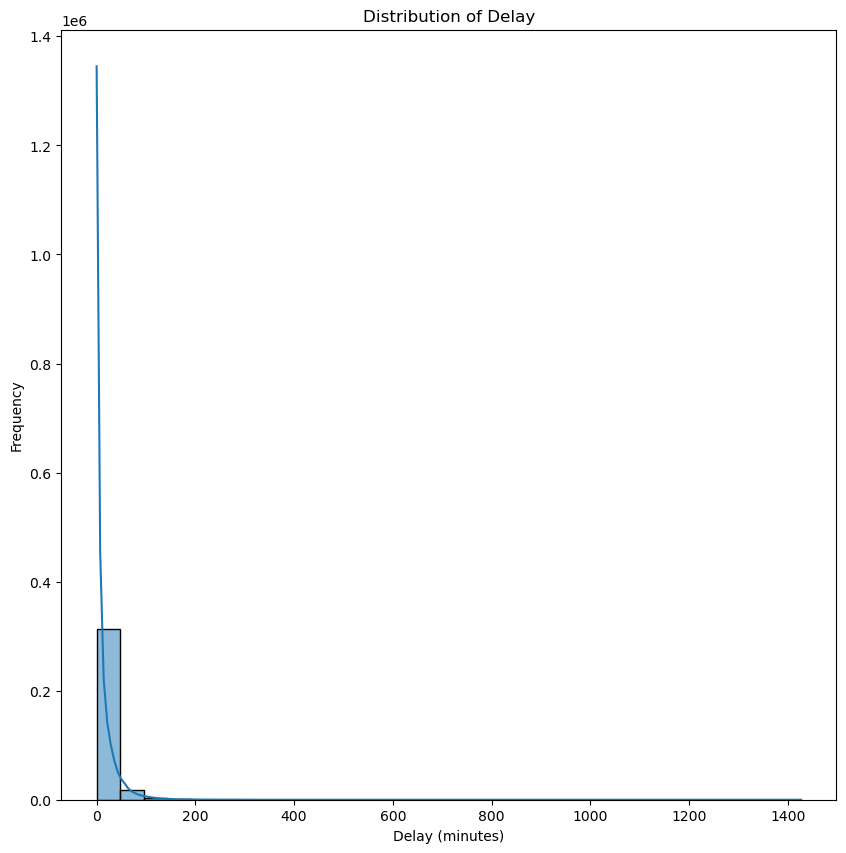

In [84]:
plt.figure(figsize=(10, 10))
sns.histplot(arrive_df['delay'], bins=30, kde=True)
plt.xlabel('Delay (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Delay')
plt.show()

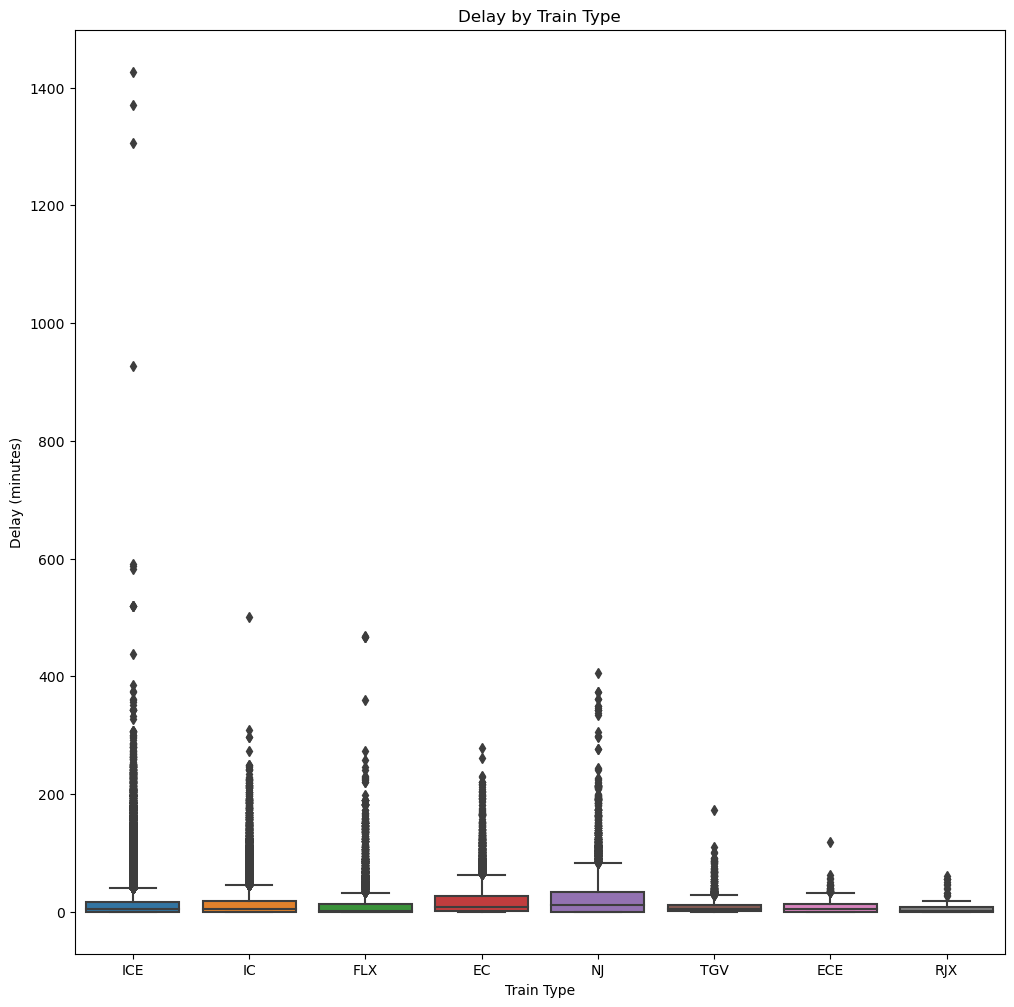

In [85]:
plt.figure(figsize=(12, 12))
sns.boxplot(x='train_type', y='delay', data=arrive_df)
plt.xlabel('Train Type')
plt.ylabel('Delay (minutes)')
plt.title('Delay by Train Type')
plt.show()

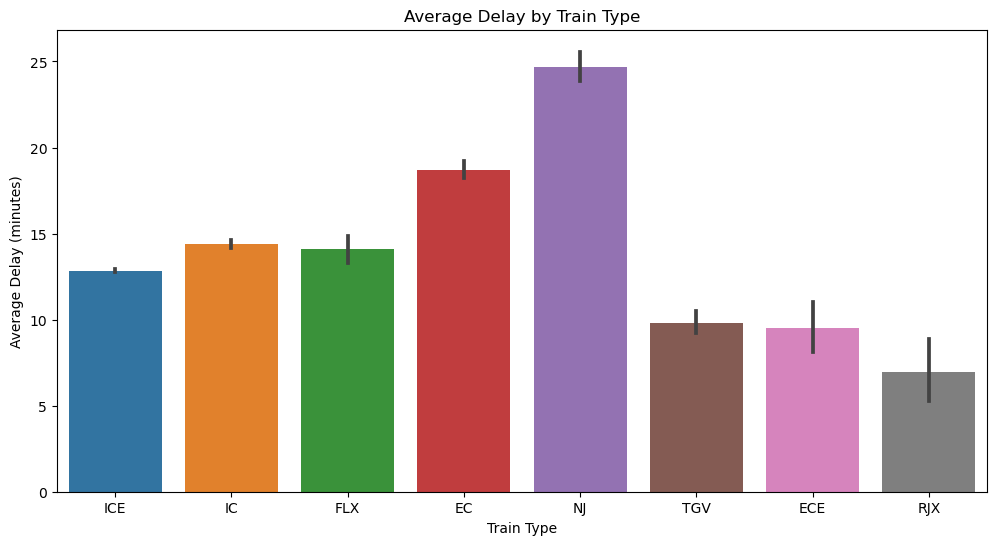

In [86]:
# Bar Plot of Average Delay by Train Type

plt.figure(figsize=(12, 6))
sns.barplot(x='train_type', y='delay', data=arrive_df)
plt.xlabel('Train Type')
plt.ylabel('Average Delay (minutes)')
plt.title('Average Delay by Train Type')
plt.show()


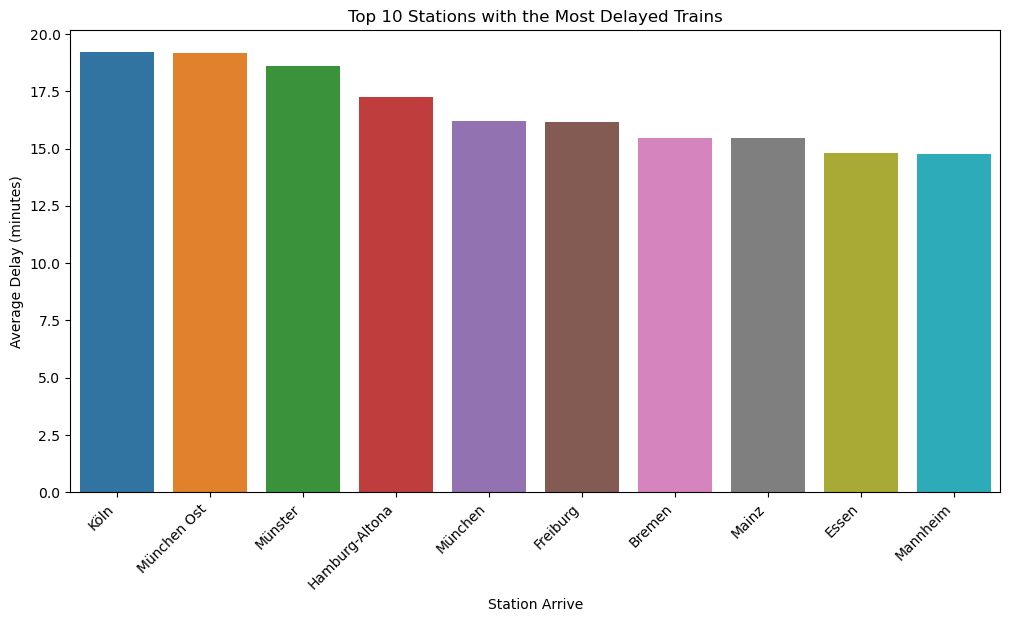

In [87]:
# Calculate the average delay for each arrival stations

avg_delay_by_station = arrive_df.groupby('station_arrive')['delay'].mean().sort_values(ascending=False)
top_10_delayed_stations = avg_delay_by_station.head(10)

# Bar Plot of the top 10 stations with the most delay

plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_delayed_stations.index, y=top_10_delayed_stations.values)
plt.xlabel('Station Arrive')
plt.ylabel('Average Delay (minutes)')
plt.title('Top 10 Stations with the Most Delayed Trains')
plt.xticks(rotation=45, ha='right')
plt.show()

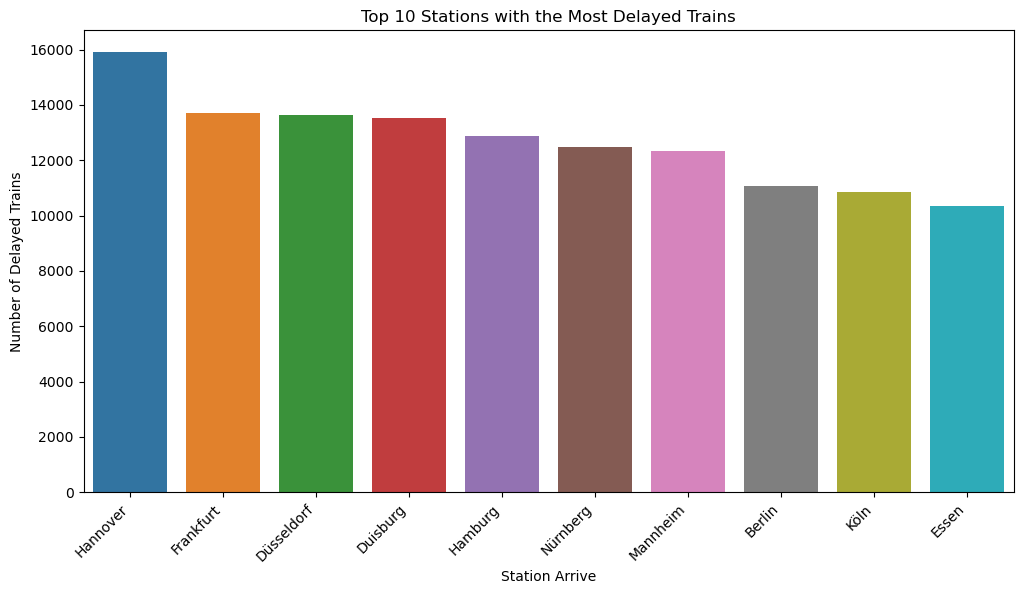

In [88]:
# Count the number of delayed trains for each arrival station

delayed_trains_by_station = arrive_df[arrive_df['delay'] > 0]['station_arrive'].value_counts().sort_values(ascending=False)
top_10_delayed_stations = delayed_trains_by_station.head(10)

# Bar plot of the top 10 stations with the most delayed trains

plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_delayed_stations.index, y=top_10_delayed_stations.values)
plt.xlabel('Station Arrive')
plt.ylabel('Number of Delayed Trains')
plt.title('Top 10 Stations with the Most Delayed Trains')
plt.xticks(rotation=45, ha='right')
plt.show()


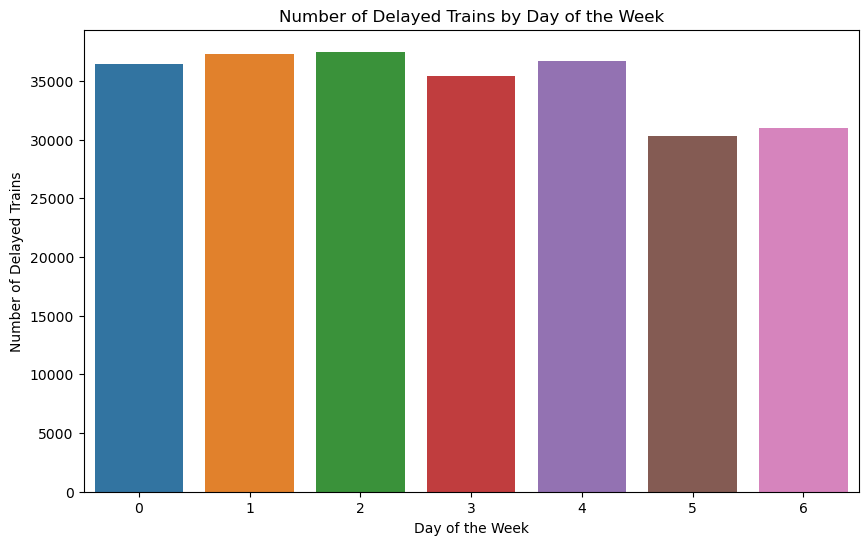

In [89]:
# Count the number of delayed trains for each day of the week

delayed_trains_by_day = arrive_df[arrive_df['delay'] > 0]['weekday'].value_counts().sort_index()

# Bar plot

plt.figure(figsize=(10, 6))
sns.barplot(x=delayed_trains_by_day.index, y=delayed_trains_by_day.values)
plt.xlabel('Day of the Week')
plt.ylabel('Number of Delayed Trains')
plt.title('Number of Delayed Trains by Day of the Week')
plt.xticks(rotation=0)
plt.show()


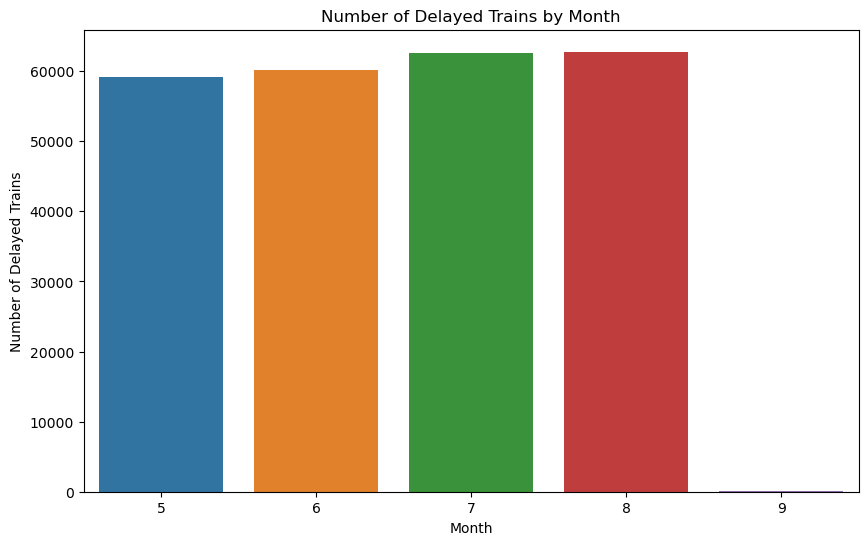

In [90]:
# Calculate delays by month

# Extract the month from the 'actual_arrive' column

arrive_df['month'] = arrive_df['actual_arrive'].dt.month
delayed_trains_by_month = arrive_df[arrive_df['delay'] > 0]['month'].value_counts().sort_index()

# Bar plot of the number of delayed trains for each month

plt.figure(figsize=(10, 6))
sns.barplot(x=delayed_trains_by_month.index, y=delayed_trains_by_month.values)
plt.xlabel('Month')
plt.ylabel('Number of Delayed Trains')
plt.title('Number of Delayed Trains by Month')
plt.xticks(rotation=0)
plt.show()

# 5. Delay Data Wrangling

In [91]:
column_order = ['train_type','train_num','time_depart'
                ,'station_depart','station_arrive', 'scheduled_arrive'
                ,'actual_arrive','month','weekday','delay','canceled']

arrive_df = arrive_df[column_order]

arrive_df

,train_type,train_num,time_depart,station_depart,station_arrive,scheduled_arrive,actual_arrive,month,weekday,delay,canceled
0,ICE,500,2022-05-01 18:56:00,München,Berlin Gesundbrunnen,2022-05-02 00:25:00,2022-05-02 00:25:00,5,6,0.0,0
1,ICE,1100,2022-05-01 19:56:00,München,Berlin Gesundbrunnen,2022-05-02 01:10:00,2022-05-02 01:10:00,5,6,0.0,0
2,IC,94,2022-05-01 19:15:00,Wien,Berlin Gesundbrunnen,2022-05-02 06:42:00,2022-05-02 06:42:00,5,6,0.0,0
3,ICE,698,2022-05-01 21:51:00,München,Berlin Gesundbrunnen,2022-05-02 08:13:00,2022-05-02 08:13:00,5,6,0.0,0
5,IC,2175,2022-05-01 07:56:00,Warnemünde,Berlin Gesundbrunnen,2022-05-01 10:17:00,2022-05-01 10:17:00,5,6,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
428590,IC,60400,2022-08-31 19:59:00,Zürich HB,Freiburg,2022-08-31 21:24:00,2022-08-31 21:56:00,8,2,32.0,0
428591,IC,60470,2022-08-31 00:52:00,Frankfurt,Freiburg,2022-08-31 21:24:00,2022-08-31 21:56:00,8,2,32.0,0
428592,ICE,203,2022-08-31 18:54:00,Köln,Freiburg,2022-08-31 21:57:00,2022-08-31 22:07:00,8,2,10.0,0
428593,ICE,1171,2022-08-31 14:39:00,Kiel,Freiburg,2022-08-31 21:24:00,2022-08-31 22:15:00,8,2,51.0,0


In this part, by observing the visualisation above, I want to dive into the 'delay' values. According to Deutsche Bahn, a train is considered delayed when it arrives at it's destination 6 minutes later than planned.

In [92]:
# Look at the mean, median and deviation of values delay

mean_delay = arrive_df['delay'].mean()
median_delay = arrive_df['delay'].median()
std_delay = arrive_df['delay'].std()


print(f'Mean Delay: {mean_delay:.2f} minutes')
print(f'Median Delay: {median_delay:.2f} minutes')
print(f'Standard Deviation of Delay: {std_delay:.2f} minutes')

display(arrive_df['delay'].value_counts())

Mean Delay: 13.51 minutes
Median Delay: 5.00 minutes
Standard Deviation of Delay: 23.55 minutes


0.0      92219
1.0      24671
2.0      19883
3.0      17128
4.0      14360
         ...  
328.0        1
362.0        1
352.0        1
344.0        1
309.0        1
Name: delay, Length: 316, dtype: int64

In [93]:
# Calculate total number of trains that were delayed by 6 minutes or longer

total_rows = len(arrive_df)
values_over_6 = len(arrive_df[arrive_df['delay'] >= 6])

percent_over_6 = (values_over_6 / total_rows) * 100

print(f'Trains with delay equal to or over 6 minutes: {percent_over_6:.2f}%')

Trains with delay equal to or over 6 minutes: 46.41%


In [94]:
# Calculate percentage of delays over 180 on total delays over 6 minutes

delays_over_6 = len(arrive_df[arrive_df['delay'] >= 6])
delays_over_180 = len(arrive_df[arrive_df['delay'] > 180])
percentage_over_180 = (delays_over_180 / delays_over_6) * 100


print(f'Percentage of delays over 180 minutes based on total over 6 minutes: {percentage_over_180:.2f}%')


Percentage of delays over 180 minutes based on total over 6 minutes: 0.40%


In [95]:
# Identify rows as outliers by setting a threshold
# Calculated some different values but decided with 6 due to 6x std_delay = approx

threshold = 9

outliers_delay = arrive_df[np.abs(arrive_df['delay'] - mean_delay) > threshold * std_delay]
# arrive_df = arrive_df.drop(outliers.index)

display(outliers_delay)

,train_type,train_num,time_depart,station_depart,station_arrive,scheduled_arrive,actual_arrive,month,weekday,delay,canceled
6019,ICE,941,2022-05-20 13:52:00,Düsseldorf,Berlin,2022-05-20 13:55:00,2022-05-20 18:15:00,5,4,260.0,0
6020,ICE,951,2022-05-20 13:48:00,Köln,Berlin,2022-05-20 13:55:00,2022-05-20 18:15:00,5,4,260.0,0
6031,ICE,641,2022-05-20 14:51:00,Düsseldorf,Berlin,2022-05-20 15:16:00,2022-05-20 19:10:00,5,4,234.0,0
6032,ICE,651,2022-05-20 14:20:00,Bonn,Berlin,2022-05-20 15:16:00,2022-05-20 19:10:00,5,4,234.0,0
8196,ICE,945,2022-06-02 17:52:00,Düsseldorf,Berlin,2022-06-02 18:34:00,2022-06-02 22:26:00,6,3,232.0,0
...,...,...,...,...,...,...,...,...,...,...,...
425155,IC,60401,2022-07-11 20:35:00,Hamburg-Altona,Freiburg,2022-07-12 02:16:00,2022-07-12 06:18:00,7,0,242.0,0
427170,EC,9,2022-08-09 06:29:00,Hamburg-Altona,Freiburg,2022-08-09 10:32:00,2022-08-09 14:53:00,8,1,261.0,0
428360,IC,60471,2022-08-28 20:54:00,Berlin,Freiburg,2022-08-29 01:10:00,2022-08-29 06:19:00,8,6,309.0,0
428361,NJ,401,2022-08-28 20:35:00,Hamburg-Altona,Freiburg,2022-08-29 01:22:00,2022-08-29 06:19:00,8,6,297.0,0


In [96]:
# Drop rows where 'delay' is greater than 180

arrive_df = arrive_df[arrive_df['delay'] <= 180]
print(arrive_df.shape) 

(336358, 11)


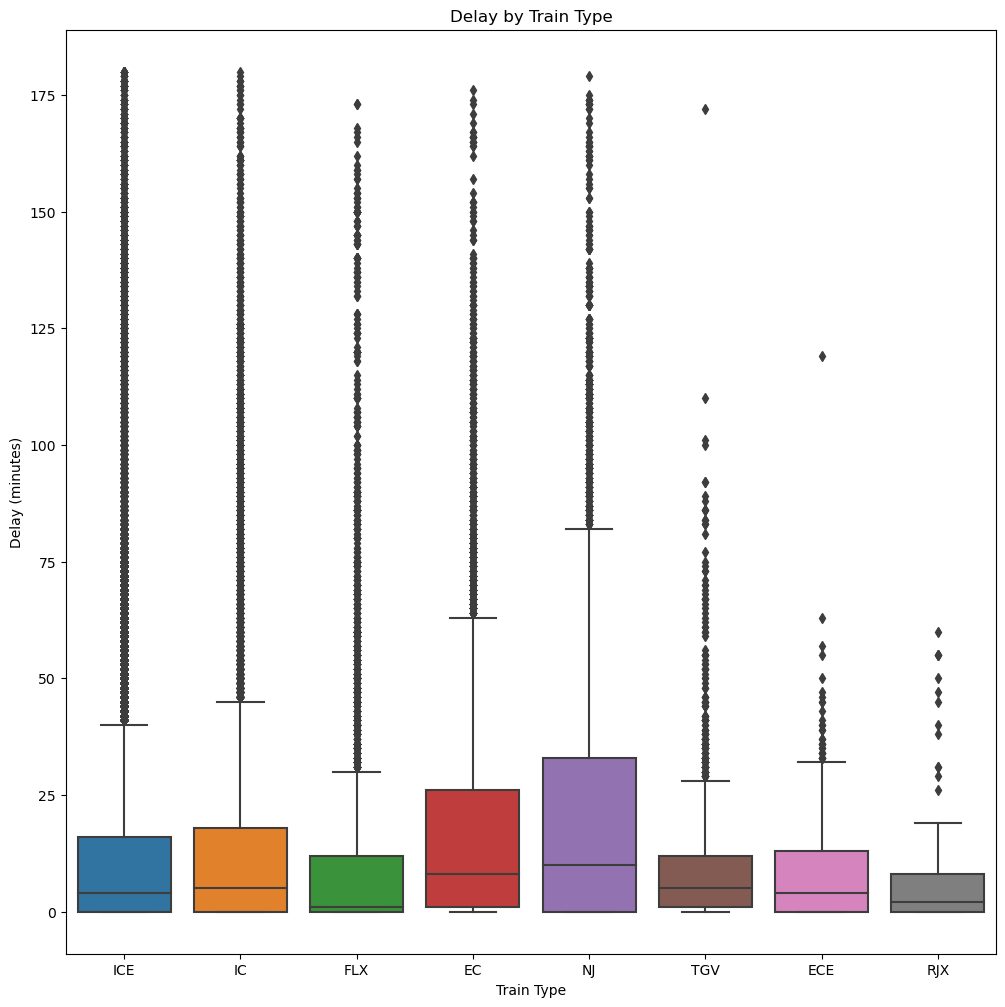

In [97]:
# Check boxplot distribution again

plt.figure(figsize=(12, 12))
sns.boxplot(x='train_type', y='delay', data=arrive_df)
plt.xlabel('Train Type')
plt.ylabel('Delay (minutes)')
plt.title('Delay by Train Type')
plt.show()

In [214]:
# Save to CSV

arrive_df.to_csv('arrive_df.csv', index=False)
stops_df.to_csv('stops_df.csv', index=False)

# 6. MySQL

In [99]:
display(arrive_df)
display(stops_df)

,train_type,train_num,time_depart,station_depart,station_arrive,scheduled_arrive,actual_arrive,month,weekday,delay,canceled
0,ICE,500,2022-05-01 18:56:00,München,Berlin Gesundbrunnen,2022-05-02 00:25:00,2022-05-02 00:25:00,5,6,0.0,0
1,ICE,1100,2022-05-01 19:56:00,München,Berlin Gesundbrunnen,2022-05-02 01:10:00,2022-05-02 01:10:00,5,6,0.0,0
2,IC,94,2022-05-01 19:15:00,Wien,Berlin Gesundbrunnen,2022-05-02 06:42:00,2022-05-02 06:42:00,5,6,0.0,0
3,ICE,698,2022-05-01 21:51:00,München,Berlin Gesundbrunnen,2022-05-02 08:13:00,2022-05-02 08:13:00,5,6,0.0,0
5,IC,2175,2022-05-01 07:56:00,Warnemünde,Berlin Gesundbrunnen,2022-05-01 10:17:00,2022-05-01 10:17:00,5,6,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
428590,IC,60400,2022-08-31 19:59:00,Zürich HB,Freiburg,2022-08-31 21:24:00,2022-08-31 21:56:00,8,2,32.0,0
428591,IC,60470,2022-08-31 00:52:00,Frankfurt,Freiburg,2022-08-31 21:24:00,2022-08-31 21:56:00,8,2,32.0,0
428592,ICE,203,2022-08-31 18:54:00,Köln,Freiburg,2022-08-31 21:57:00,2022-08-31 22:07:00,8,2,10.0,0
428593,ICE,1171,2022-08-31 14:39:00,Kiel,Freiburg,2022-08-31 21:24:00,2022-08-31 22:15:00,8,2,51.0,0


,stop_name,stop_id,stop_lat,stop_lon
0,'s-Hertogenbosch,351617,51.69054,5.293723
3,Aachen Süd,412112,50.731915,6.04541
5,Aachen,168299,50.767723,6.092051
6,Aalen,473812,48.841602,10.096031
9,Aarhus,484274,56.150074,10.204997
...,...,...,...,...
1617,Zürich Flughafen,52098,47.450386,8.562402
1619,Zürich HB,104196,47.378178,8.540212
1621,Züssow,620099,53.97505,13.547026
1625,Ötztal,237368,47.238483,10.859114


In [ ]:
schedule_df = schedule_df[schedule_df['time_depart'].dt.month != 9]
schedule_df = schedule_df[schedule_df['actual_arrive'].dt.month != 9]

schedule_df

In [104]:
import pymysql                       
from sqlalchemy import create_engine 

username = 'root'
password = 'R43m4n2k'
host = 'localhost'
port = '3306'
database_name = 'ironhack_db'

engine = create_engine(f'mysql+pymysql://{username}:{password}@{host}:{port}/{database_name}')

In [101]:
arrive_df.to_sql('arrive', con=engine, index=False, if_exists='replace')
stops_df.to_sql('stops', con=engine, index=False, if_exists='replace')

591

In [130]:
# MySQL to DataFrame

connection = pymysql.connect(host='localhost', user='root', password='R43m4n2k', database='ironhack_db')
query = f"SELECT * FROM schedule"

schedule_df = pd.read_sql(query, connection)
connection.close()
schedule_df.to_csv('schedule_df.csv', index=False)

/var/folders/yq/dfhgy0yx0t3dm3n1xyhjfyjw0000gn/T/ipykernel_17702/1906531969.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  schedule_df = pd.read_sql(query, connection)


In [216]:
schedule_df['late'] = (schedule_df['delay'] >= 6).astype(int)
print(schedule_df.head(30))

   train_type train_num         time_depart  station_depart  \
0         ICE       500 2022-05-01 18:56:00         München   
1         ICE      1100 2022-05-01 19:56:00         München   
2          IC        94 2022-05-01 19:15:00            Wien   
3         ICE       698 2022-05-01 21:51:00         München   
4          IC      2175 2022-05-01 07:56:00      Warnemünde   
5          IC       245 2022-05-01 07:33:00         Münster   
6         ICE      1042 2022-05-01 08:19:00  Ostseebad Binz   
7          IC      2177 2022-05-01 09:56:00      Warnemünde   
8         ICE       694 2022-05-01 06:50:00       Stuttgart   
9          IC      2178 2022-05-01 11:19:00         Dresden   
10        ICE      1710 2022-05-01 08:55:00         München   
11        ICE      1711 2022-05-01 10:21:00  Ostseebad Binz   
12         IC      2179 2022-05-01 11:56:00      Warnemünde   
13        ICE       692 2022-05-01 06:29:00         München   
14        ICE       759 2022-05-01 09:34:00            

In [217]:
schedule_df.to_csv('schedule_df.csv', index=False)

# 6. Visualisation

Let's look ito time trends on delays and trips

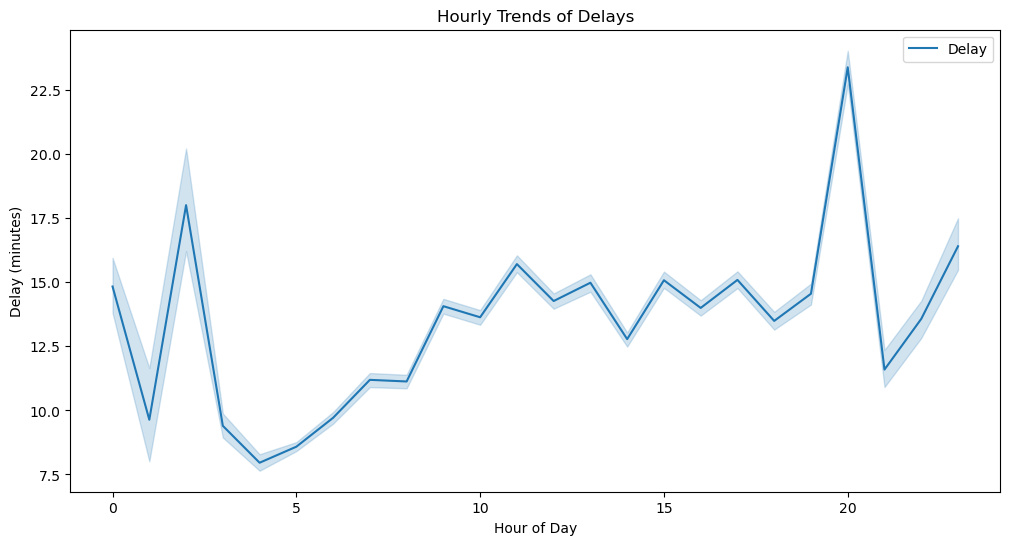

In [197]:
# Time trends for delays

schedule_df['hour_of_day'] = schedule_df['time_depart'].dt.hour

plt.figure(figsize=(12, 6))
sns.lineplot(x='hour_of_day', y='delay', data=schedule_df, label='Delay')

plt.xlabel('Hour of Day')
plt.ylabel('Delay (minutes)')
plt.title('Hourly Trends of Delays')
plt.legend()


plt.show()

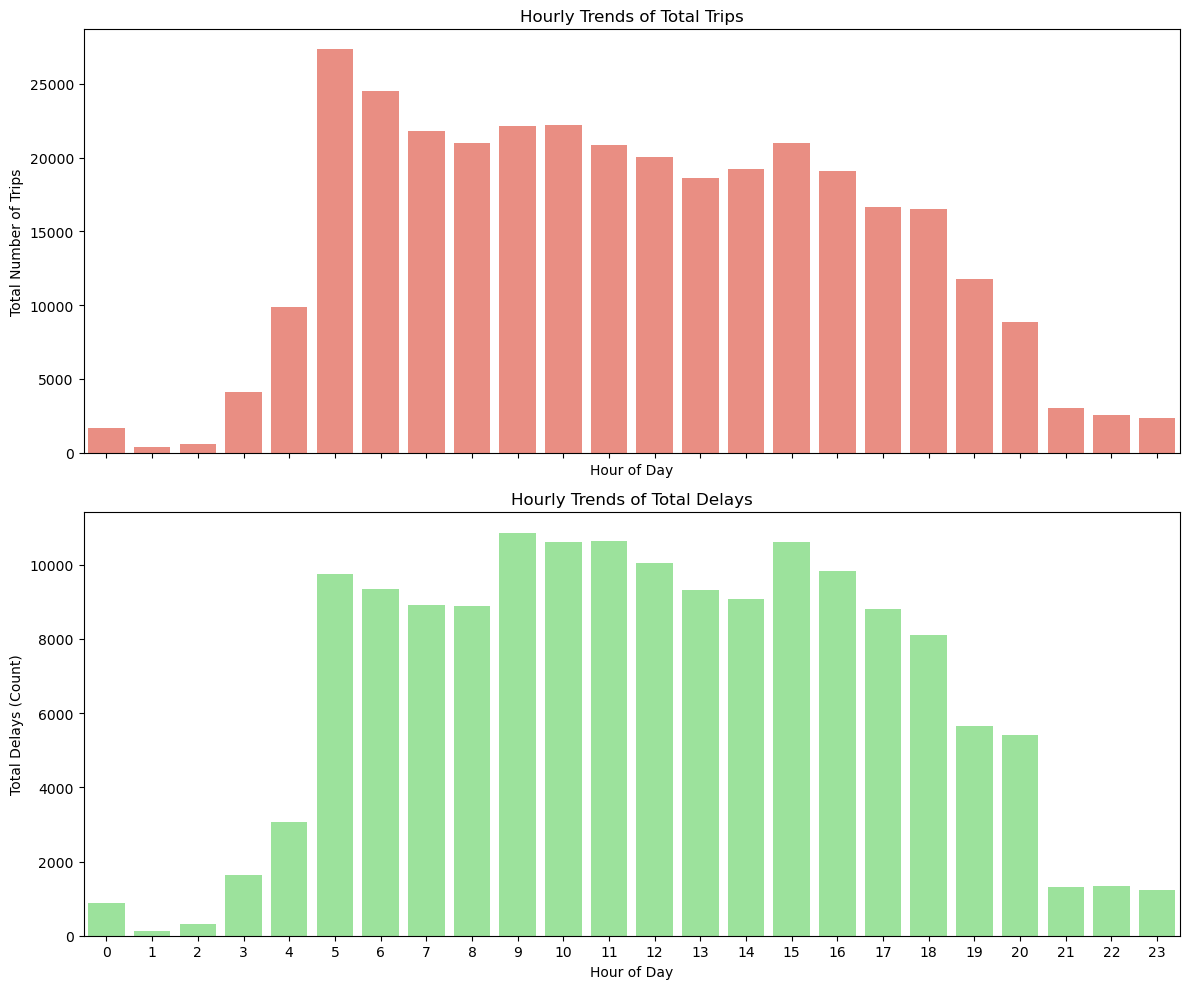

In [198]:
# Total Trips & Delays

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), sharex=True)

ax2 = axes[0]
total_trips = schedule_df.groupby('hour_of_day').size().reset_index(name='total_trips')
sns.barplot(x='hour_of_day', y='total_trips', data=total_trips, ax=ax2, color='salmon')
ax2.set_xlabel('Hour of Day')
ax2.set_ylabel('Total Number of Trips')
ax2.set_title('Hourly Trends of Total Trips')

ax3 = axes[1]
total_delays = schedule_df[schedule_df['delay'] >= 6].groupby('hour_of_day').size().reset_index(name='total_delays')
sns.barplot(x='hour_of_day', y='total_delays', data=total_delays, ax=ax3, color='lightgreen')
ax3.set_xlabel('Hour of Day')
ax3.set_ylabel('Total Delays (Count)')
ax3.set_title('Hourly Trends of Total Delays')


plt.tight_layout()
plt.show()



# 7. Create Model

In [199]:
schedule_df.dtypes
schedule_df = schedule_df.drop(columns='hour_of_day', errors='ignore')

In [200]:
# Move HOUR column

current_index = schedule_df.columns.get_loc('hour')
new_index = 9
schedule_df.insert(new_index, 'hour', schedule_df.pop('hour'))

In [218]:
schedule_df.dtypes

train_type                  object
train_num                   object
time_depart         datetime64[ns]
station_depart              object
station_arrive              object
scheduled_arrive    datetime64[ns]
actual_arrive       datetime64[ns]
month                       object
weekday                     object
hour                        object
delay                      float64
canceled                    object
arrive_id                    int64
depart_id                    int64
arrive_lat                 float64
arrive_lon                 float64
depart_lat                 float64
depart_lon                 float64
distance                   float64
late                         int64
dtype: object

In [219]:
# Onehot Encoding

encoder = OneHotEncoder(drop='first', sparse=False)
encoded_cols = encoder.fit_transform(schedule_df[['train_type', 'train_num', 'station_depart', 'station_arrive', 'month','weekday','hour', 'canceled','late']])
encoded_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(['train_type', 'train_num', 'station_depart', 'station_arrive', 'month','weekday','hour', 'canceled','late']))

/Users/hysteria/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [220]:
encoded_df

,train_type_ECE,train_type_FLX,train_type_IC,train_type_ICE,train_type_NJ,train_type_RJX,train_type_TGV,train_num_1000,train_num_1001,train_num_1002,...,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,canceled_1,late_1
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336170,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
336171,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
336172,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
336173,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [221]:
# Scale Numerical Data

numerical_column = schedule_df['distance'].values.reshape(-1, 1)

scaler = StandardScaler()
scaled_values = scaler.fit_transform(numerical_column)

scaled_df = pd.DataFrame(scaled_values, columns=['distance'])

In [222]:
processed_df = pd.concat([encoded_df, scaled_df], axis=1)

In [223]:
display(processed_df)

,train_type_ECE,train_type_FLX,train_type_IC,train_type_ICE,train_type_NJ,train_type_RJX,train_type_TGV,train_num_1000,train_num_1001,train_num_1002,...,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,canceled_1,late_1,distance
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.101521
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.101521
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.226027
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.101521
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.606394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336170,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.241861
336171,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.373891
336172,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.136101
336173,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.289944


In [239]:
# X-y Split

X = processed_df
y = schedule_df['delay']

## Regression Model Testing

In [240]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [209]:
# Linear Regression

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 372.4184368848192


In [210]:
# Random Forest Regressor

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f'Random Forest Mean Squared Error: {mse_rf}')

Random Forest Mean Squared Error: 464.4855683736035


In [211]:
# Decision Tree Regressor

dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

y_pred_dt = dt_model.predict(X_test)

mse_dt = mean_squared_error(y_test, y_pred_dt)
print(f'Decision Tree Mean Squared Error: {mse_dt}')

Decision Tree Mean Squared Error: 525.838050928336


## Classification Testing

In [226]:
# Logistic Regression 

X = processed_df.drop('late_1', axis=1)
y = schedule_df['late']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()

model.fit(X_train, y_train)

predictions = model.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)

print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(report)

Accuracy: 0.69

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.72      0.71     36147
           1       0.67      0.65      0.66     31088

    accuracy                           0.69     67235
   macro avg       0.69      0.69      0.69     67235
weighted avg       0.69      0.69      0.69     67235



/Users/hysteria/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Interim Model Conclusion

Looking at the MSE scores above for the models, I can conclude that perhaps I do not have enough numerical values to help build a good predictive models to calculate a numerical target. 

When building a simple simple binary classification (1,0) prediction, this seems to work better in predicting whether the train will be delayed or not based on a YES/No.

# 8. Building a Prediction Program

Unfortunately I don't have confidence in building a prediction program that allows me to accurately predict the percentage and duration of delay. I would have to relook at the data set and define a new objective. The code below doesn't unfortunately work.

In [248]:
schedule_df.dtypes

train_type                  object
train_num                   object
time_depart         datetime64[ns]
station_depart              object
station_arrive              object
scheduled_arrive    datetime64[ns]
actual_arrive       datetime64[ns]
month                       object
weekday                     object
hour                        object
delay                      float64
canceled                    object
arrive_id                    int64
depart_id                    int64
arrive_lat                 float64
arrive_lon                 float64
depart_lat                 float64
depart_lon                 float64
distance                   float64
late                         int64
dtype: object

In [352]:
# X = schedule_df[['station_depart', 'station_arrive', 'weekday', 'hour', 'distance']]
# y = schedule_df['delay']

In [353]:
# # Transform data

# numerical_features = ['distance']
# categorical_features = ['station_depart', 'station_arrive', 'weekday', 'hour']

# numerical_transformer = StandardScaler()
# categorical_transformer = OneHotEncoder(drop='first', sparse=False)

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numerical_transformer, numerical_features),
#         ('cat', categorical_transformer, categorical_features)
#     ])

In [354]:
# # Create a pipeline with the preprocessor and the regressor

# model = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('regressor', RandomForestRegressor())
# ])

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# model.fit(X_train, y_train)

/Users/hysteria/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['distance']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['station_depart',
                                                   'station_arrive', 'weekday',
                                                   'hour'])])),
                ('regressor', RandomForestRegressor())])

In [371]:
# # Function to Predict Delay

# def predict_delay(departure, arrive, day_of_week, hour_of_day, model):

#     valid_departures = schedule_df['station_depart'].unique()
#     valid_arrives = schedule_df['station_arrive'].unique()

#     if departure not in valid_departures or arrive not in valid_arrives:
#         print("Invalid departure or arrive values. Valid values are:")
#         print("Departures:", valid_departures)
#         print("Arrives:", valid_arrives)
#         return

#      try:
#         day_of_week_numeric = int(day_of_week)
#         if day_of_week_numeric < 0 or day_of_week_numeric > 6:
#             raise ValueError
#     except ValueError:
#         print("Invalid day_of_week value. Please enter a number between 0 and 6.")
#         return

#      try:
#         hour_of_day_numeric = int(hour_of_day)
#         if not (0 <= hour_of_day_numeric <= 24):
#             raise ValueError
#     except ValueError:
#         print("Invalid hour_of_day value. Please enter a number between 0 and 24.")
#         return

 
#     user_input_df = pd.DataFrame({
#         'station_depart': [departure],
#         'station_arrive': [arrive],
#         'weekday': [day_of_week_numeric],
#         'hour': [hour_of_day_numeric],
#         'distance': [0]
#     })

#     user_input_processed = preprocessor.transform(user_input_df)   
#     user_input_processed_df = pd.DataFrame(user_input_processed, columns=processed_df.columns)
#     prediction = model.predict(user_input_processed_df)[0]

     
#     print(f"Based on the input, there is a {prediction:.2%} chance of the train being delayed.")

#     if prediction > 0.5:
#         # If there is a high chance of delay, calculate the predicted delay in minutes
#         predicted_delay = model.named_steps['regressor'].predict(user_input_processed_df)[0]
#         print(f"The predicted delay is approximately {predicted_delay:.2f} minutes.")
#     else:
#         print("The model predicts that the train will not be delayed.")


In [372]:
# # Function to take input from user

# def get_user_input():
    
#     departure = input("Enter the departure station: ")
#     arrive = input("Enter the arrival station: ")

#     valid_departures = schedule_df['station_depart'].unique()
#     valid_arrives = schedule_df['station_arrive'].unique()

#     while departure not in valid_departures or arrive not in valid_arrives:
#         print("Invalid departure or arrive values. Valid values are:")
#         print("Departures:", valid_departures)
#         print("Arrives:", valid_arrives)
#         departure = input("Enter the departure station: ")
#         arrive = input("Enter the arrival station: ")

#      valid_days = schedule_df['weekday'].unique()
#     print("Valid day_of_week values are:", valid_days)

#     while True:
#         day_of_week = input("Enter the day of the week: ")
#         try:
#             day_of_week_numeric = int(day_of_week)
#             if day_of_week_numeric in valid_days:
#                 break
#             else:
#                 raise ValueError
#         except ValueError:
#             print("Invalid day_of_week value. Please enter a valid numeric value.")

#     while True:
#         hour_of_day = input("Enter the hour of the day (0-24): ")
#         try:
#             hour_of_day_numeric = int(hour_of_day)
#             if not (0 <= hour_of_day_numeric <= 24):
#                 raise ValueError
#             break
#         except ValueError:
#             print("Invalid hour_of_day value. Please enter a number between 0 and 24.")

#     return departure, arrive, day_of_week_numeric, hour_of_day_numeric


In [373]:
# # Test Model

# departure, arrive, day_of_week, hour_of_day = get_user_input()
# predict_delay(departure, arrive, day_of_week, hour_of_day, model)

Enter the departure station: Berlin
Enter the arrival station: Hamburg
Valid day_of_week values are: [6 0 1 2 3 4 5]
Enter the day of the week: 3
Enter the hour of the day (0-24): 12


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

# 9. Further Feature Visualisations

I want to further understand the feature importance, if I had to do another version of the prediction model, to reshape  the approach already before doing the model. 

This is something I perhaps should've focused on first to drop unecessary features. However, after looking, the feature selection is based quite a lot of categorical values and I'm not convinced if eliminating certain sub-attributes within the features would help.

/var/folders/yq/dfhgy0yx0t3dm3n1xyhjfyjw0000gn/T/ipykernel_17702/3681729063.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = correlation_data.corr()


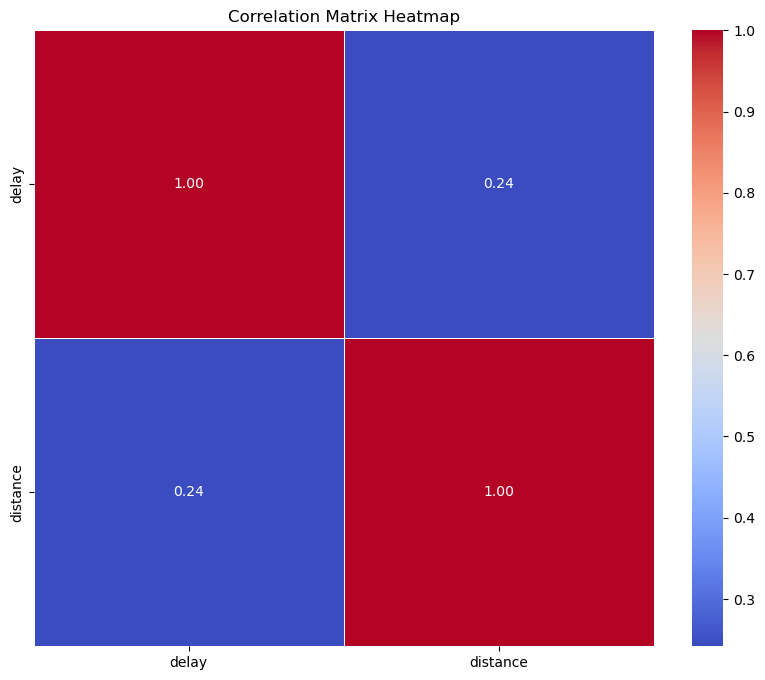

In [320]:
# Correlation Matrix and Heatmap

correlation_data = schedule_df[['train_type', 'weekday', 'hour','delay','distance']]
correlation_matrix = correlation_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [328]:
X = schedule_df[['train_type', 'train_num', 'station_depart', 'station_arrive', 'month', 'weekday', 'hour']]
y = schedule_df['delay']

/Users/hysteria/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


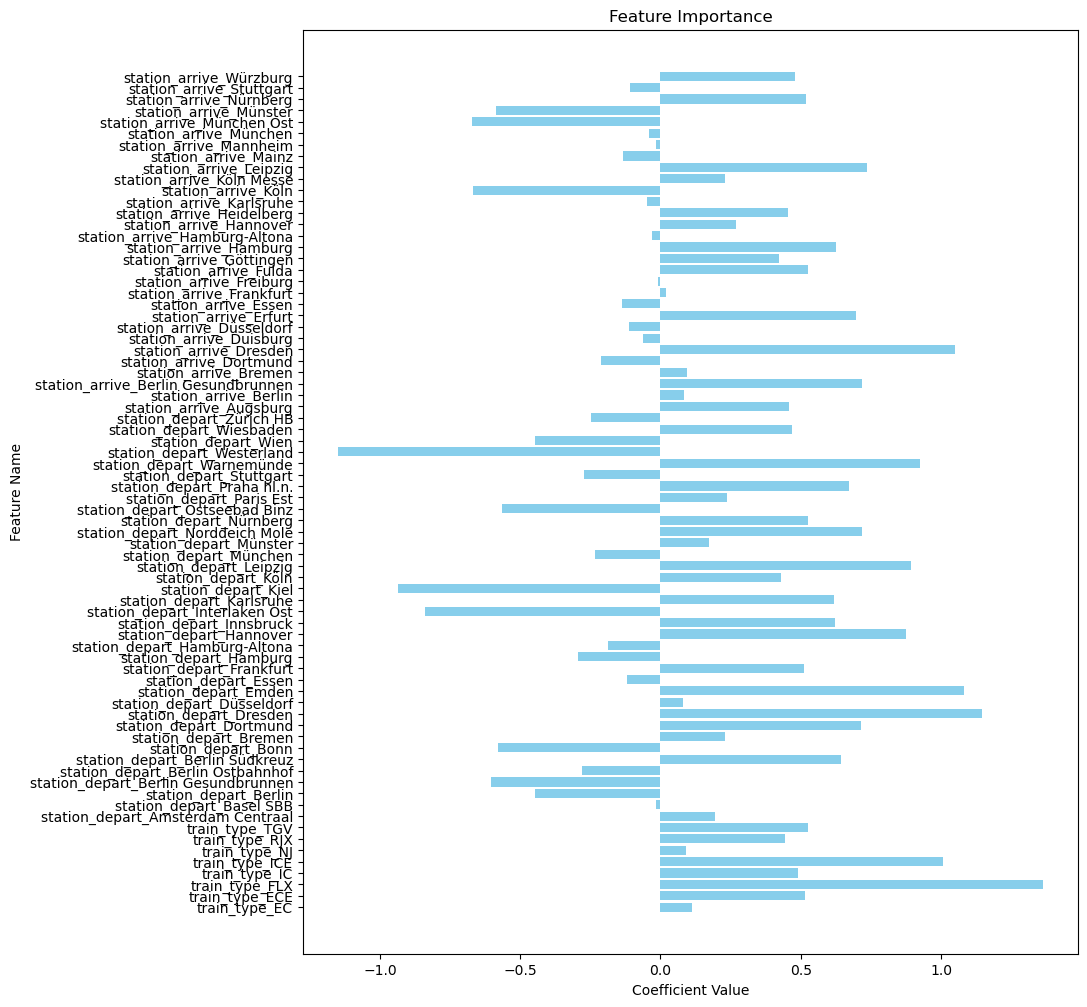

In [335]:
# Feature Importance (Train Departures)

X = schedule_df[['train_type', 'station_depart', 'station_arrive']]
y = schedule_df['delay']


categorical_columns = ['train_type', 'station_depart', 'station_arrive'] 

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X.columns.difference(categorical_columns)),
        ('cat', OneHotEncoder(), categorical_columns)
    ])


pipeline = make_pipeline(preprocessor, LogisticRegression())

pipeline.fit(X, y)

logreg_model = pipeline.named_steps['logisticregression']

numeric_feature_names = pipeline.named_steps['columntransformer'].transformers_[0][1].get_feature_names_out(X.columns.difference(categorical_columns))
categorical_feature_names = pipeline.named_steps['columntransformer'].transformers_[1][1].get_feature_names_out(categorical_columns)
feature_names = list(numeric_feature_names) + list(categorical_feature_names)

feature_importances = logreg_model.coef_[0]

plt.figure(figsize=(10, 12))
plt.barh(feature_names, feature_importances, color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Name')
plt.title('Feature Importance')
plt.show()


/Users/hysteria/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


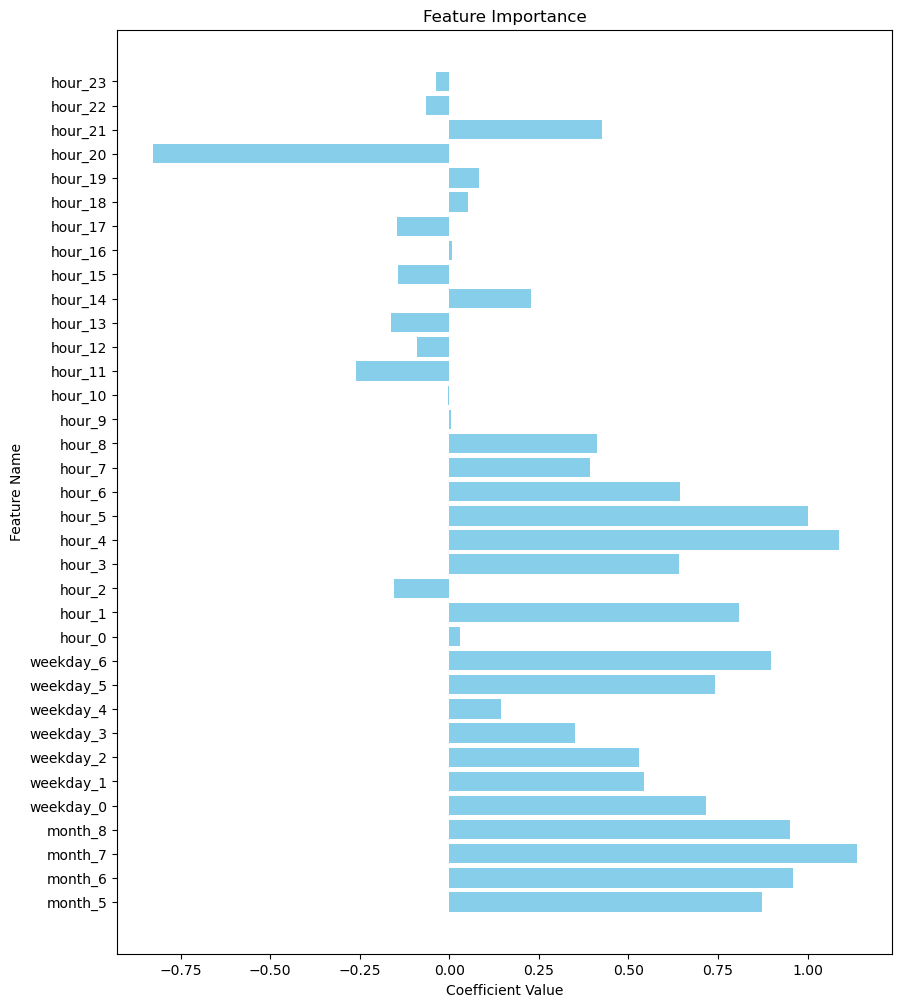

In [336]:
# Date Values

X = schedule_df[['month', 'weekday', 'hour']]
y = schedule_df['delay']

categorical_columns = ['month', 'weekday', 'hour']  # Add other categorical columns as needed

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X.columns.difference(categorical_columns)),
        ('cat', OneHotEncoder(), categorical_columns)
    ])

pipeline = make_pipeline(preprocessor, LogisticRegression())

pipeline.fit(X, y)

logreg_model = pipeline.named_steps['logisticregression'] 


numeric_feature_names = pipeline.named_steps['columntransformer'].transformers_[0][1].get_feature_names_out(X.columns.difference(categorical_columns))
categorical_feature_names = pipeline.named_steps['columntransformer'].transformers_[1][1].get_feature_names_out(categorical_columns)
feature_names = list(numeric_feature_names) + list(categorical_feature_names)

feature_importances = logreg_model.coef_[0]

plt.figure(figsize=(10, 12))
plt.barh(feature_names, feature_importances, color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Name')
plt.title('Feature Importance')
plt.show()


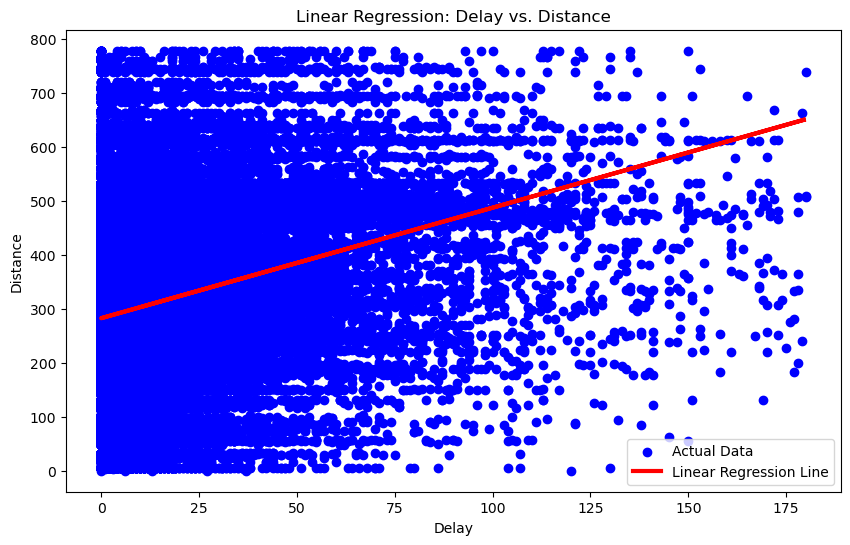

In [376]:
# Linear Regression Graph

X = schedule_df[['delay']]
y = schedule_df['distance']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)

predictions = model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual Data')
plt.plot(X_test, predictions, color='red', linewidth=3, label='Linear Regression Line')
plt.xlabel('Delay')
plt.ylabel('Distance')
plt.title('Linear Regression: Delay vs. Distance')
plt.legend()
plt.show()

# 10. Conclusion

I completely underestimated that the dimensions of the data had a very negative impact on the model and I was not able to create a functional version with a decent MSE score. Making adjustments to dataset I was at least able to improve the binary classification score but my objective to predict delay times the information I had available was not able to model this. 

My conclusion on this project is:

- I needed more numerical values (having only two in sufficient for a dataset this size)
- Distance between stations did not impact the delay times as much as I have expected
- Focus on perhaps more granular clusters of the train network (regions rather than national), this way there delay times could perhaps be more correlated to nearby stations
- Missing passenger dimension could have helped improve the model but this is inconclusive.